<a href="https://colab.research.google.com/github/monika-the-unicorn/Choice-assay/blob/main/Copy_of_3_Data_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook takes concatenated data and converts it into feeding/activity bout data ready for visualisation

## Setup and data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("plyr", repos="http://cran.us.r-project.org")

(as ‘lib’ is unspecified)







	‘/tmp/Rtmp2EH5QZ/downloaded_packages’



In [ ]:
%%R
#Load the libraries
library(ggplot2)
library(dplyr)
library(stringr)
library(lubridate)
library(tidyverse)
library(plyr)

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’



    date, intersect, setdiff, union




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.1
✔ readr   2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)


Attaching package: ‘plyr’



    compact



    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




In [ ]:
%%R
#data <- read.csv(list.files("/content/drive/My Drive/BeecamData/Quinine pilot/DLC_output/", full.names = TRUE,
#      pattern = "all_data_to_round")[[1]])
data <- read.csv("/content/drive/My Drive/BeecamData/Nicotine/DLC_output/proboscis_data.csv")

#data <- data[ , !grepl("X|Unnamed", names(data))]
head(data)

  Frame Tube_prob_y End_prob_y Time_seconds     Time_in_experiment
1    20    52.02579   51.22535          4.0        0 days 05:57:01
2    21    94.37484   98.00436          4.2 0 days 05:57:01.200000
3    22   104.35641  141.00220          4.4 0 days 05:57:01.400000
4    23   103.37175  103.57816          4.6 0 days 05:57:01.600000
5    24   100.46986  100.75327          4.8 0 days 05:57:01.800000
6    25   106.78474  110.40199          5.0        0 days 05:57:02
               Clock_time  Tube   RPi
1 2024-08-23 20:59:13.000 right RPi7_
2 2024-08-23 20:59:13.200 right RPi7_
3 2024-08-23 20:59:13.400 right RPi7_
4 2024-08-23 20:59:13.600 right RPi7_
5 2024-08-23 20:59:13.800 right RPi7_
6 2024-08-23 20:59:14.000 right RPi7_
                                                                    Video Round
1 right_23-08-2024_20-59-09DLC_resnet50_Beecam_v4Jun25shuffle1_201000.csv     1
2 right_23-08-2024_20-59-09DLC_resnet50_Beecam_v4Jun25shuffle1_201000.csv     1
3 right_23-08-2024_20-59-

In [ ]:
%%R
#List unique values of Round (to check correct copy loaded)
unique(data$Round)

 [1]  1  2  3  4  5  6  7  8  9 10


## Data cleaning and organisation

### Convert time in experiment variable to a time variable that R can use

In [ ]:
%%R
characters.wanted <- c(8:17)
strings_to_change <- data$Time_in_experiment
new_strings <- sapply(strsplit(strings_to_change, ''), function(x) {
  paste(x[characters.wanted], collapse = '')
})
#Remove NAs
library(stringr)
new_strings2 <- str_replace_all(new_strings, "([NANA])", "")
new_strings2

data$Plot_time <- new_strings2
head(data)

  Frame Tube_prob_y End_prob_y Time_seconds     Time_in_experiment
1    20    52.02579   51.22535          4.0        0 days 05:57:01
2    21    94.37484   98.00436          4.2 0 days 05:57:01.200000
3    22   104.35641  141.00220          4.4 0 days 05:57:01.400000
4    23   103.37175  103.57816          4.6 0 days 05:57:01.600000
5    24   100.46986  100.75327          4.8 0 days 05:57:01.800000
6    25   106.78474  110.40199          5.0        0 days 05:57:02
               Clock_time  Tube   RPi
1 2024-08-23 20:59:13.000 right RPi7_
2 2024-08-23 20:59:13.200 right RPi7_
3 2024-08-23 20:59:13.400 right RPi7_
4 2024-08-23 20:59:13.600 right RPi7_
5 2024-08-23 20:59:13.800 right RPi7_
6 2024-08-23 20:59:14.000 right RPi7_
                                                                    Video Round
1 right_23-08-2024_20-59-09DLC_resnet50_Beecam_v4Jun25shuffle1_201000.csv     1
2 right_23-08-2024_20-59-09DLC_resnet50_Beecam_v4Jun25shuffle1_201000.csv     1
3 right_23-08-2024_20-59-

### Identify bouts of feeding and proboscis out activity

####Produce time variable and order data

In [ ]:
%%R
#Change plot_time to a format that can be compared
data <- dplyr::mutate(data,
                    Num_time = lubridate::hms(Plot_time),
                    Time_min = as.numeric(Num_time)/60)

head(data)

  Frame Tube_prob_y End_prob_y Time_seconds     Time_in_experiment
1    20    52.02579   51.22535          4.0        0 days 05:57:01
2    21    94.37484   98.00436          4.2 0 days 05:57:01.200000
3    22   104.35641  141.00220          4.4 0 days 05:57:01.400000
4    23   103.37175  103.57816          4.6 0 days 05:57:01.600000
5    24   100.46986  100.75327          4.8 0 days 05:57:01.800000
6    25   106.78474  110.40199          5.0        0 days 05:57:02
               Clock_time  Tube   RPi
1 2024-08-23 20:59:13.000 right RPi7_
2 2024-08-23 20:59:13.200 right RPi7_
3 2024-08-23 20:59:13.400 right RPi7_
4 2024-08-23 20:59:13.600 right RPi7_
5 2024-08-23 20:59:13.800 right RPi7_
6 2024-08-23 20:59:14.000 right RPi7_
                                                                    Video Round
1 right_23-08-2024_20-59-09DLC_resnet50_Beecam_v4Jun25shuffle1_201000.csv     1
2 right_23-08-2024_20-59-09DLC_resnet50_Beecam_v4Jun25shuffle1_201000.csv     1
3 right_23-08-2024_20-59-

In [ ]:
%%R
#Check for NAs in dataset
head(data)
nrow(data)
colSums(is.na(data))
#Remove any present
data_no_na <- data %>% na.omit() #For some reason there were a load of NAs at the bottom of the round 1 dataset (I think because the rbind didn't work when I combined round 1a and 1b)

In [ ]:
%%R
#Find RPi variable type
class(data_no_na$RPi)

#Change it to a factor
data_no_na$RPi <- as.factor(data_no_na$RPi)

#Rename the RPi factor values. If it ends in '_', use the 4th character, else use the 4th and 5th
current_levels <- levels(data_no_na$RPi)
# Define a function to rename levels based on the condition
rename_levels <- function(level) {
  if (grepl("_$", level)) {
    # If the level ends with '_', get the 4th character
    return(substr(level, 4, 4))
  } else {
    # Otherwise, get the 4th and 5th characters
    return(substr(level, 4, 5))
  }
}

# Apply the renaming function to each level
new_levels <- sapply(current_levels, rename_levels)

print(new_levels)

RPi1_ RPi10 RPi2_ RPi3_ RPi4_ RPi5_ RPi6_ RPi7_ RPi8_ RPi9_ 
  "1"  "10"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9" 


In [ ]:
%%R
# Assign the new levels to the factor
levels(data_no_na$RPi) <- new_levels

In [ ]:
%%R
#FOR QUININE
#Find the RPi number of the entries with video value containing the string "left_26-07-2024_15-46-16"
data_no_na[grep("left_26-07-2024_15-46-16", data_no_na$Video),]$RPi

factor()
Levels: 1 10 2 3 4 5 6 7 8 9


In [ ]:
%%R
# Order the dataframe by RPi, Num_time, and Value
ordered_data <- data_no_na %>%
  arrange(Round, RPi, Num_time)

In [ ]:
%%R
#nrow(ordered_data)
print(knitr::kable(ordered_data[1:100,]))



| Frame| Tube_prob_y| End_prob_y| Time_seconds|Time_in_experiment     |Clock_time              |Tube  |RPi |Video                                                                   | Round| Tube_prob_likelihood| End_prob_likelihood|Behaviour |Plot_time  |  Num_time|  Time_min|
|-----:|-----------:|----------:|------------:|:----------------------|:-----------------------|:-----|:---|:-----------------------------------------------------------------------|-----:|--------------------:|-------------------:|:---------|:----------|---------:|---------:|
|     0|    58.85661|  221.23419|          0.0|0 days 00:03:44        |2024-08-23 14:11:07.000 |left  |1   |left_23-08-2024_14-11-07DLC_resnet50_Beecam_v4Jun25shuffle1_201000.csv  |     1|            0.0057878|           0.9941108|Prob_out  |00:03:44   |    3M 44S|  3.733333|
|     1|   181.99466|  184.34871|          0.2|0 days 00:03:44.200000 |2024-08-23 14:11:07.200 |left  |1   |left_23-08-2024_14-11-07DLC_resnet50_Beecam_v4Jun25shuffle1

#### Find where activity bouts start and end

In [ ]:
%%R
library(dplyr)

# Arrange data and calculate time difference
ordered_activity_data <- ordered_data %>%
    arrange(Round, RPi, Num_time) %>%
    group_by(RPi) %>%
    # Calculate time difference in minutes from the previous frame
    mutate(mins_since_prev_frame = Time_min - lag(Time_min),
           Activity_bout = ifelse(is.na(mins_since_prev_frame) | mins_since_prev_frame > 0.083333, "Start_bout", "0")) %>%
    ungroup()

# Remove consecutive 'Start_bout' entries (treat the first in each sequence as the true start)
ordered_activity_data <- ordered_activity_data %>%
    group_by(RPi) %>%
    mutate(previous_activity = lag(Activity_bout)) %>%
    filter(!(Activity_bout == "Start_bout" & previous_activity == "Start_bout")) %>%
    ungroup()

# Add 'End_bout' labels before each new 'Start_bout' (while excluding the last row in each group to avoid overflow)
ordered_activity_data <- ordered_activity_data %>%
    group_by(RPi) %>%
    mutate(Activity_bout = ifelse(lead(Activity_bout) == "Start_bout", "End_bout", Activity_bout)) %>%
    ungroup()

# Remove any stray 'Start_bout' entries at the end of each RPi's data
ordered_activity_data <- ordered_activity_data %>%
    group_by(RPi) %>%
    filter(!(row_number() == n() & Activity_bout == "Start_bout")) %>%
    ungroup()

# Check counts of 'Start_bout' and 'End_bout' to verify they are balanced
table(ordered_activity_data$Activity_bout)


         0   End_bout Start_bout 
    470876       9545       9543 


In [ ]:
%%R
library(dplyr)

ordered_drinking_data <- ordered_activity_data[which(ordered_activity_data$Behaviour == "Drinking"),] %>%
    group_by(RPi) %>%
    # Calculate time difference in minutes from the previous frame
    dplyr::mutate(mins_since_prev_frame = Time_min - lag(Time_min),
           Drinking_bout = ifelse(is.na(mins_since_prev_frame) | mins_since_prev_frame > 0.083333, "Start_bout", "0")) %>%
    ungroup()

ordered_drinking_data <- ordered_drinking_data %>%
    group_by(RPi) %>%
    # Identify previous and next activities
    dplyr::mutate(
        previous_activity = lag(Activity_bout),
        next_activity = lead(Activity_bout)
    ) %>%
    # Remove 'Start_bout' if it is not followed by a '0'
    filter(!(Activity_bout == "Start_bout" & next_activity != "0")) %>%
    # Un-group the data
    ungroup() %>%
    # Ensure the last 'Start_bout' is preserved if it's valid
    group_by(RPi) %>%
    dplyr::mutate(
        # Keep the last 'Start_bout' in the group if it has '0' next to it
        Activity_bout = ifelse(row_number() == n() & next_activity == "0", "Start_bout", Activity_bout)
    ) %>%
    ungroup() %>%
    select(-previous_activity, -next_activity)  # Remove helper columns if no longer needed

# Add 'End_bout' labels before each new 'Start_bout' (while excluding the last row in each group to avoid overflow)
ordered_drinking_data <- ordered_drinking_data %>%
    group_by(RPi) %>%
    dplyr::mutate(Activity_bout = ifelse(lead(Activity_bout) == "Start_bout", "End_bout", Activity_bout)) %>%
    ungroup()

# Check counts of 'Start_bout' and 'End_bout' to verify they are balanced
table(ordered_drinking_data$Activity_bout)



         0   End_bout Start_bout 
    288934       1138        821 


In [ ]:
%%R
#Find where drinking bouts start and end
drinking_data <- ordered_activity_data[which(ordered_activity_data$Behaviour == "Drinking"),]

# Arrange data and calculate time difference
ordered_drinking_data <- ordered_data %>%
    arrange(Round, RPi, Num_time) %>%
    group_by(RPi) %>%
    # Calculate time difference in minutes from the previous frame
    mutate(mins_since_prev_frame = Time_min - lag(Time_min),
           Activity_bout = ifelse(is.na(mins_since_prev_frame) | mins_since_prev_frame > 0.083333, "Start_bout", "0")) %>%
    ungroup()

# Remove consecutive 'Start_bout' entries (treat the last in each sequence as the true start)
ordered_drinking_data <- ordered_drinking_data %>%
    group_by(RPi) %>%
    mutate(previous_activity = lag(Activity_bout)) %>%
    filter(!(Activity_bout == "Start_bout" & previous_activity == "Start_bout")) %>%
    ungroup()

# Add 'End_bout' labels before each new 'Start_bout' (while excluding the last row in each group to avoid overflow)
ordered_drinking_data <- ordered_drinking_data %>%
    group_by(RPi) %>%
    mutate(Activity_bout = ifelse(lead(Activity_bout) == "Start_bout", "End_bout", Activity_bout)) %>%
    ungroup()

# Remove any stray 'Start_bout' entries at the end of each RPi's data
ordered_drinking_data <- ordered_drinking_data %>%
    group_by(RPi) %>%
    filter(!(row_number() == n() & Activity_bout == "Start_bout")) %>%
    ungroup()

# Check counts of 'Start_bout' and 'End_bout' to verify they are balanced
table(ordered_drinking_data$Activity_bout)

SyntaxError: invalid syntax (<ipython-input-16-b0a95afff716>, line 2)

Previous method:

In [ ]:
%%R
# Group by RPi and identify breaks in time series
ordered_activity_data_2 <- ordered_data %>%
    group_by(RPi) %>%
    dplyr::mutate(mins_since_prev_frame = Time_min - lag(Time_min)) %>%
    # Label start of a new activity bout
    dplyr::mutate(Activity_bout = ifelse(mins_since_prev_frame > 0.083333 | is.na(mins_since_prev_frame), "Start_bout", "0")) %>%
    dplyr::mutate(previous_activity = lag(Activity_bout)) %>%
    # Remove erroneous consecutive Start_bouts
    filter(!(Activity_bout == "Start_bout" & previous_activity == "Start_bout")) %>%
    # Ungroup before assigning a sequential entry_ID
    ungroup() %>%
    dplyr::mutate(entry_ID = row_number())

# Output the cleaned dataset
ordered_activity_data_2


# A tibble: 489,958 × 20
   Frame Tube_prob_y End_prob_y Time_seconds Time_in_experiment Clock_time Tube 
   <dbl>       <dbl>      <dbl>        <dbl> <chr>              <chr>      <chr>
 1     1       182.       184.           0.2 0 days 00:03:44.2… 2024-08-2… left 
 2     2        84.3       85.1          0.4 0 days 00:03:44.4… 2024-08-2… left 
 3     3        42.0       46.0          0.6 0 days 00:03:44.6… 2024-08-2… left 
 4     4        26.6       33.8          0.8 0 days 00:03:44.8… 2024-08-2… left 
 5    21        30.2       34.0          4.2 0 days 00:03:48.2… 2024-08-2… left 
 6    22        15.1       20.7          4.4 0 days 00:03:48.4… 2024-08-2… left 
 7    24        30.5       33.4          4.8 0 days 00:03:48.8… 2024-08-2… left 
 8    25        23.7       26.2          5   0 days 00:03:49    2024-08-2… left 
 9    31        63.3       17.4          6.2 0 days 00:03:50.2… 2024-08-2… left 
10    41       298.       302.           8.2 0 days 00:03:52.2… 2024-08-2… left 
# ℹ

---

In [ ]:
%%R
ordered_data$Activity_bout <- 0
#Identify breaks in the time series (separate filming activity periods, each representative of general proboscis activity) and number them
  #Create a function that groups by RPi and loops through the plot times comparing to the previous.
  #If >5s between them, set new activity bout number
ordered_activity_data_2 <- ordered_data %>%
    group_by(RPi) %>%
    mutate(mins_since_prev_frame = Time_min - lag(Time_min)) %>%
#If difference > 0.0833333, label as start of activity bout (and label lag row as end)
    mutate(Activity_bout = ifelse(mins_since_prev_frame > 0.083333, "Start_bout", "0"))

In [ ]:
#If new rpi, mins since prev frame will be negative. Change this to NA and activity bout to Start_bout
%%R
ordered_activity_data_2$mins_since_prev_frame[ordered_activity_data_2$mins_since_prev_frame < 0] <- NA
ordered_activity_data_2[which(is.na(ordered_activity_data_2$mins_since_prev_frame)),]$Activity_bout <- "Start_bout"

In [ ]:
%%R
#If two consecutive 'Start_bout' when ordered appropriately, remove the one above (use lag function)
  #A single frame of proboscis action will have been an error
#i.e. if activity_bout = start_bout and lag activity_bout = start_bout, modify lag
ordered_activity_data_2 <- ordered_activity_data_2 %>%
  mutate(previous_activity = lag(Activity_bout))

In [ ]:
%%R
#If both are start_bout, the row above is an error and can be removed (i.e. take one off the entry_ID and remove)
ordered_activity_data_2$entry_ID <- 1:nrow(ordered_activity_data_2)
error_frames <- ordered_activity_data_2[which(ordered_activity_data_2$Activity_bout == "Start_bout" & ordered_activity_data_2$previous_activity=="Start_bout"),]$entry_ID - 1
data_minuserror <- ordered_activity_data_2[!(ordered_activity_data_2$entry_ID %in% error_frames),]

In [ ]:
%%R
#If the final entry of data_minuserror has an Activity_bout value of Start_bout, remove it
if (data_minuserror[nrow(data_minuserror),]$Activity_bout == "Start_bout"){
  data_minuserror <- data_minuserror[-nrow(data_minuserror),]
}

In [ ]:
%%R
#Check if all entries labelled as either start bout or 0
(nrow(data_minuserror[which(data_minuserror$Activity_bout == "Start_bout"),])+ nrow(data_minuserror[which(data_minuserror$Activity_bout == "0"),]) )/ nrow(data_minuserror)

[1] 1


Add end bouts

In [ ]:
%%R
# Add End_bout entries
data_minuserror_end <- data_minuserror %>%
  group_by(RPi) %>%
  mutate(
    Activity_bout = ifelse(lead(Activity_bout) == "Start_bout", "End_bout", Activity_bout)
  ) %>%
  ungroup()

In [ ]:
%%R
nrow(data_minuserror_end)

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
#Print only the rows which have an Activity_bout value of either Start_bout or End_bout
#print(knitr::kable(data_minuserror_end[which(data_minuserror_end$Activity_bout == "Start_bout" | data_minuserror_end$Activity_bout == "End_bout"),]))

#print(knitr::kable(data_minuserror_end[73440:73446,]))



|RPi |Tube  |Behaviour |Time_in_experiment       | Frame| Tube_prob|  End_prob| Time_seconds|Clock_time              |Video                                                                           | Round|Plot_time  |     Num_time|   Time_min|Activity_bout | mins_since_prev_frame|previous_activity | entry_ID|
|:---|:-----|:---------|:------------------------|-----:|---------:|---------:|------------:|:-----------------------|:-------------------------------------------------------------------------------|-----:|:----------|------------:|----------:|:-------------|---------------------:|:-----------------|--------:|
|10  |left  |Prob_out  |0 days 00:01:37          |     5| 0.0075222| 0.9936738|          1.0|2024-06-12 12:52:31.000 |0.0                                                                             |     1|00:01:37   |       1M 37S|   1.616667|Start_bout    |                    NA|NA                |        1|
|10  |left  |Prob_out  |0 days 00:03:46.400000   |   607| 0.26

In [ ]:
%%R
nrow(data_minuserror_end[which(data_minuserror_end$Activity_bout == "Start_bout"),])

[1] 9593


In [ ]:
%%R
nrow(data_minuserror_end[which(data_minuserror_end$Activity_bout == "End_bout"),])

[1] 9592


In [ ]:
%%R
#View the final entry of data_minuserror_end
print(knitr::kable(data_minuserror_end[nrow(data_minuserror_end),]))



| Frame| Tube_prob_y| End_prob_y| Time_seconds|Time_in_experiment       |Clock_time              |Tube  |RPi |Video                                                                   | Round| Tube_prob_likelihood| End_prob_likelihood|Behaviour |Plot_time |    Num_time| Time_min|Activity_bout | mins_since_prev_frame|previous_activity | entry_ID|
|-----:|-----------:|----------:|------------:|:------------------------|:-----------------------|:-----|:---|:-----------------------------------------------------------------------|-----:|--------------------:|-------------------:|:---------|:---------|-----------:|--------:|:-------------|---------------------:|:-----------------|--------:|
|    81|    112.2844|   105.6259|         16.2|-1 days +23:50:43.200000 |2024-09-06 17:40:34.200 |right |9   |right_06-09-2024_17-40-18DLC_resnet50_Beecam_v4Jun25shuffle1_186000.csv |    10|            0.6765274|           0.0223474|Prob_out  |+23:50:43 | 23H 50M 43S| 1430.717|NA            |             

In [ ]:
%%R
#If the final entry of data_minuserror has an Activity_bout value of Start_bout, remove it
if (data_minuserror_end[nrow(data_minuserror_end),]$Activity_bout == "Start_bout"){
  data_minuserror_end <- data_minuserror_end[-nrow(data_minuserror_end),]
}

#If the penultimate entry in the dataset has an Activity_bout value of "End_bout", remove the final entry
if (data_minuserror_end[nrow(data_minuserror_end)-1,]$Activity_bout == "End_bout"){
  data_minuserror_end <- data_minuserror_end[-nrow(data_minuserror_end),]
}

  missing value where TRUE/FALSE needed




Error in if (data_minuserror_end[nrow(data_minuserror_end), ]$Activity_bout ==  : 
  missing value where TRUE/FALSE needed


In [ ]:
%%R
#Label the final entry as an End_bout
data_minuserror_end[nrow(data_minuserror_end),]$Activity_bout <- "End_bout"

In [ ]:
%%R
print(knitr::kable(data_minuserror_end[nrow(data_minuserror_end),]))



| Frame| Tube_prob_y| End_prob_y| Time_seconds|Time_in_experiment       |Clock_time              |Tube  |RPi |Video                                                                   | Round| Tube_prob_likelihood| End_prob_likelihood|Behaviour |Plot_time |    Num_time| Time_min|Activity_bout | mins_since_prev_frame|previous_activity | entry_ID|
|-----:|-----------:|----------:|------------:|:------------------------|:-----------------------|:-----|:---|:-----------------------------------------------------------------------|-----:|--------------------:|-------------------:|:---------|:---------|-----------:|--------:|:-------------|---------------------:|:-----------------|--------:|
|    81|    112.2844|   105.6259|         16.2|-1 days +23:50:43.200000 |2024-09-06 17:40:34.200 |right |9   |right_06-09-2024_17-40-18DLC_resnet50_Beecam_v4Jun25shuffle1_186000.csv |    10|            0.6765274|           0.0223474|Prob_out  |+23:50:43 | 23H 50M 43S| 1430.717|End_bout      |             

When labelling the final entry, check that it is actually part of the previous bout

In [ ]:
%%R
#Check there are equal numbers of bout start and end points
nrow(data_minuserror_end[which(data_minuserror_end$Activity_bout == "Start_bout"),]) #/ nrow(data_minuserror_end[which(data_minuserror_end$Activity_bout == "End_bout"),])

[1] 9593


####Label separate feeding bouts with an individual number, and use this identifying variable to record each bout duration

In [ ]:
%%R
data_minuserror_bouts <- data_minuserror_end %>%
  mutate(Bout_no = cumsum(Activity_bout == "Start_bout"))

In [ ]:
%%R
# Calculate the duration of each bout
All_activity_bout_durations <- data_minuserror_bouts %>%
  group_by(Bout_no) %>%
  dplyr::summarise(duration = max(Time_min) - min(Time_min)) %>%
  ungroup()

In [ ]:
%%R
head(All_activity_bout_durations)

# A tibble: 6 × 2
  Bout_no duration
    <int>    <dbl>
1       1   0.253 
2       2   0.190 
3       3   0.233 
4       4   0.567 
5       5   0.0400
6       6   0.240 


In [ ]:
%%R
#print(knitr::kable(All_activity_bout_durations))
seconds_fed <- All_activity_bout_durations$duration * 60

####Histogram of bout durations

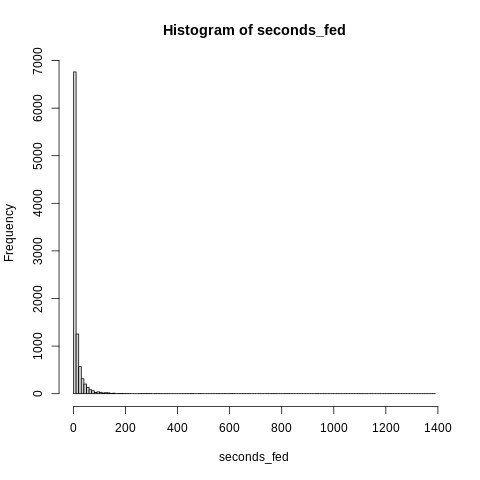

In [ ]:
%%R
hist(seconds_fed, breaks = 100)

In [ ]:
%%R
#hist(All_activity_bout_durations[which(All_activity_bout_durations$)])

seconds_fed <- All_activity_bout_durations$duration * 60

###Add other relevant information to the feeding bout dataset
Referencing start_bout entries as a useful individual representative source of info

In [ ]:
%%R
#nrow(data_minuserror_bouts[which(data_minuserror_bouts$Activity_bout == "Start_bout"),])
nrow(All_activity_bout_durations)
#Both should have the same value

[1] 9593


In [ ]:
%%R
All_activity_bout_durations$Tube <- data_minuserror_bouts[which(data_minuserror_bouts$Activity_bout == "Start_bout"),]$Tube #Get the relevant tube information to add to the cumulative dataframe
All_activity_bout_durations$Plot_time <- data_minuserror_bouts[which(data_minuserror_bouts$Activity_bout == "End_bout"),]$Plot_time #Using this so can plot amount eaten after feeding
All_activity_bout_durations$Num_time <- data_minuserror_bouts[which(data_minuserror_bouts$Activity_bout == "End_bout"),]$Num_time
All_activity_bout_durations$Time_min <- data_minuserror_bouts[which(data_minuserror_bouts$Activity_bout == "End_bout"),]$Time_min
All_activity_bout_durations$RPi <- data_minuserror_bouts[which(data_minuserror_bouts$Activity_bout == "Start_bout"),]$RPi
All_activity_bout_durations$Round <- data_minuserror_bouts[which(data_minuserror_bouts$Activity_bout == "Start_bout"),]$Round

In [ ]:
%%R
All_activity_bout_durations$Tube <- plyr::revalue(All_activity_bout_durations$Tube, c("left" = "L", "right" = "R"))
head(All_activity_bout_durations)

# A tibble: 6 × 9
  Bout_no duration Tube  Plot_time  Num_time  Time_min RPi   Round index
    <int>    <dbl> <chr> <chr>      <Period>     <dbl> <fct> <int> <int>
1       1   0.253  L     00:03:59.2 3M 59.2S      3.99 1         1     1
2       2   0.190  R     00:06:34.2 6M 34.2S      6.57 1         1     2
3       3   0.233  L     00:12:33.4 12M 33.4S    12.6  1         1     3
4       4   0.567  R     00:14:01.6 14M 1.6S     14.0  1         1     4
5       5   0.0400 R     00:14:09   14M 9S       14.2  1         1     5
6       6   0.240  L     00:15:11.8 15M 11.8S    15.2  1         1     6


###Read blinds files to find out what solution bees were feeding on in each bout

In [ ]:
%%R
blinds <- read.csv(list.files("/content/drive/My Drive/BeecamData/Nicotine/Blinds/", full.names = TRUE,
      pattern = "all_blinds_to_round")[[1]])

blinds <- blinds[ , !grepl("X", names(blinds))]
head(blinds)

  Round RPi  Treatment Pre_exp_treat Tube Solution  Start    End Change Notes
1     1   1 Nic_choice      Nicotine    L        S 3.5891 3.3763 0.2128 Alive
2     1   1 Nic_choice      Nicotine    R        N 3.4986 3.3611 0.1375 Alive
3     1   2 Nic_choice      Nicotine    L        S 3.5942 3.5211 0.0731  Died
4     1   2 Nic_choice      Nicotine    R        N 3.5070 3.4131 0.0939  Died
5     1   3 Nic_choice      Nicotine    L        S 3.5472 3.3198 0.2274 Alive
6     1   3 Nic_choice      Nicotine    R        N 3.5096 3.3681 0.1415 Alive


Calculate amount eaten (for later use in individual preference index calculations)

In [ ]:
%%R
tail(blinds)

    Round RPi    Treatment Pre_exp_treat Tube Solution  Start    End Change
155    10   8 Nic_nochoice      Nicotine    L       S2 3.5308 3.3150 0.2158
156    10   8 Nic_nochoice      Nicotine    R       S1 3.3602 3.2959 0.0643
157    10   9 Nic_nochoice      Nicotine    L       S1 3.5283 3.4208 0.1075
158    10   9 Nic_nochoice      Nicotine    R       S2 3.5227 3.3918 0.1309
159    10  10 Nic_nochoice      Nicotine    L       S1 3.5804 3.4460 0.1344
160    10  10 Nic_nochoice      Nicotine    R       S2 3.6133 3.4994 0.1139
    Notes
155 Alive
156 Alive
157 Alive
158 Alive
159 Alive
160 Alive


In [ ]:
%%R
#Find the evap entries
evap_entries <- blinds[which(blinds$RPi == "Evap"),]
evap_entries

     Date  RPi Tube Solution  Start    End Change Notes Round
61  25/07 Evap             Q 3.7330 3.7214 0.0116           4
62  25/07 Evap             S 3.7802 3.7677 0.0125           4
103 29/07 Evap             Q 3.7808 3.7618  0.019           5
104 29/07 Evap             S 3.7493 3.7306 0.0187           5


In [ ]:
%%R
#Calculate the mean change value for the evap entries
#mean_evap_pertube <- mean(as.numeric(evap_entries$Change))
mean_evap_pertube <- 0.01545

In [ ]:
%%R
blinds_mapping <- data.frame(blinds$Round, blinds$RPi, blinds$Treatment, blinds$Pre_exp_treat, blinds$Tube, blinds$Solution, blinds$Notes)

In [ ]:
%%R
blinds_mapping <- blinds_mapping[which(blinds_mapping$blinds.RPi != "Evap"),]
# Reorder the dataframe
blinds_mapping$blinds.RPi <- as.numeric(blinds_mapping$blinds.RPi)
ordered_blinds_mapping <- blinds_mapping %>%
  arrange(blinds.Round, blinds.RPi)
ordered_blinds_mapping

    blinds.Round blinds.RPi blinds.Treatment blinds.Pre_exp_treat blinds.Tube
1              1          1       Nic_choice             Nicotine           L
2              1          1       Nic_choice             Nicotine           R
3              1          2       Nic_choice             Nicotine           L
4              1          2       Nic_choice             Nicotine           R
5              1          3       Nic_choice             Nicotine           L
6              1          3       Nic_choice             Nicotine           R
7              1          4       Nic_choice             Nicotine           L
8              1          4       Nic_choice             Nicotine           R
9              1          5       Nic_choice             Nicotine           L
10             1          5       Nic_choice             Nicotine           R
11             1          6       Nic_choice             Nicotine           L
12             1          6       Nic_choice             Nicotin

In [ ]:
%%R
#Rename columns in the blinds dataframe
names(ordered_blinds_mapping)[names(ordered_blinds_mapping) == "blinds.RPi"] <- "RPi"
names(ordered_blinds_mapping)[names(ordered_blinds_mapping) == "blinds.Tube"] <- "Tube"
names(ordered_blinds_mapping)[names(ordered_blinds_mapping) == "blinds.Solution"] <- "Solution"
names(ordered_blinds_mapping)[names(ordered_blinds_mapping) == "blinds.Round"] <- "Round"
names(ordered_blinds_mapping)[names(ordered_blinds_mapping) == "blinds.Pre_exp_treat"] <- "Pre_exposure"
names(ordered_blinds_mapping)[names(ordered_blinds_mapping) == "blinds.Treatment"] <- "Treatment"
names(ordered_blinds_mapping)[names(ordered_blinds_mapping) == "blinds.Notes"] <- "Mitigation_info"

Merge the blinds (mapping) data frame with All_activity_bout_durations

In [ ]:
%%R
# Add an index column to the activity bout durations data to preserve the original order
All_activity_bout_durations$index <- seq_len(nrow(All_activity_bout_durations))
All_activity_bout_durations_solution <- merge(All_activity_bout_durations, ordered_blinds_mapping, by = c("RPi", "Tube", "Round"), all.x = TRUE)
All_activity_bout_durations_solution <- All_activity_bout_durations_solution[order(All_activity_bout_durations_solution$index), ] # Re-order merged df to match the original order
#ll_activity_bout_durations_solution$index <- NULL # Remove the index column bc no longer needed

head(All_activity_bout_durations_solution)

    RPi Tube Round Bout_no  duration  Plot_time  Num_time  Time_min index
66    1    L     1       1 0.2533333 00:03:59.2  3M 59.2S  3.986667     1
652   1    R     1       2 0.1900000 00:06:34.2  6M 34.2S  6.570000     2
68    1    L     1       3 0.2333333 00:12:33.4 12M 33.4S 12.556667     3
649   1    R     1       4 0.5666667 00:14:01.6  14M 1.6S 14.026667     4
655   1    R     1       5 0.0400000   00:14:09    14M 9S 14.150000     5
71    1    L     1       6 0.2400000 00:15:11.8 15M 11.8S 15.196667     6
     Treatment Pre_exposure Solution Mitigation_info
66  Nic_choice     Nicotine        S           Alive
652 Nic_choice     Nicotine        N           Alive
68  Nic_choice     Nicotine        S           Alive
649 Nic_choice     Nicotine        N           Alive
655 Nic_choice     Nicotine        N           Alive
71  Nic_choice     Nicotine        S           Alive


In [ ]:
%%R
# Ensure the data is sorted correctly
activity_data <- All_activity_bout_durations_solution %>%
  arrange(Round, RPi)

#Subset only living bees and rpi != 8
activity_data <- activity_data[which(activity_data$Mitigation_info == "Alive" & activity_data$RPi != 8),]

# Compute cumulative duration within each RPi/Round/Solution group
activity_data <- activity_data %>%
  group_by(Treatment, Solution) %>%
  dplyr::mutate(Cumulative_Duration = cumsum(duration)) %>%
  ungroup()

#print(knitr::kable(activity_data[1:100,]))

In [ ]:
%%R
all_activity_data_cumulative_2minmax <- activity_data[which(activity_data$duration < 2),] %>%
  arrange(Num_time) %>%
  group_by(Treatment, Solution) %>%
  dplyr::mutate(Cumulative_Duration_overall = cumsum(duration)) %>%
  ungroup()

In [ ]:
%%R
all_activity_data_cumulative <- activity_data %>%
  arrange(Num_time) %>%
  group_by(Treatment, Solution) %>%
  dplyr::mutate(Cumulative_Duration_overall = cumsum(duration)) %>%
  ungroup()

In [ ]:
%%R
print(knitr::kable(all_activity_data_cumulative[1:30,]))



|RPi |Tube | Round| Bout_no|  duration|Plot_time  | Num_time|  Time_min| index|Treatment    |Pre_exposure |Solution |Mitigation_info | Cumulative_Duration| Cumulative_Duration_overall|
|:---|:----|-----:|-------:|---------:|:----------|--------:|---------:|-----:|:------------|:------------|:--------|:---------------|-------------------:|---------------------------:|
|1   |L    |    10|    7198| 0.1233333|00:00:39   |      39S| 0.6500000|  7198|Nic_nochoice |Nicotine     |S2       |Alive           |           183.74667|                   0.1233333|
|7   |R    |     7|    4633| 0.3500000|00:00:40   |      40S| 0.6666667|  4633|Nic_choice   |Nicotine     |N        |Alive           |           206.58667|                   0.3500000|
|1   |L    |    10|    7199| 0.0133333|00:00:46.2 |    46.2S| 0.7700000|  7199|Nic_nochoice |Nicotine     |S2       |Alive           |           183.76000|                   0.1366667|
|5   |L    |     4|    3187| 0.7733333|00:00:48.4 |    48.4S| 0.8066667| 

## PLOT: Cumulative time interacting with each food source (proboscis in contact/out; separated by other activity bouts by 5+ seconds)

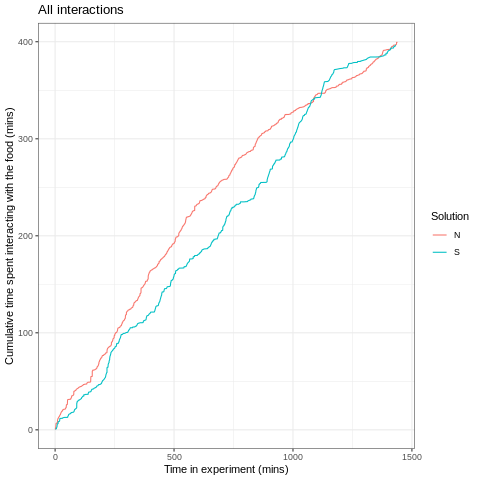

In [ ]:
%%R
ggplot(all_activity_data_cumulative[which(all_activity_data_cumulative$Treatment == "Nic_choice"),], aes(x = Time_min, y = Cumulative_Duration_overall, color = Solution)) +
  geom_line() +
  theme_bw() +
  ylab("Cumulative time spent interacting with the food (mins)") +
  xlab("Time in experiment (mins)") +
  ggtitle("All interactions")

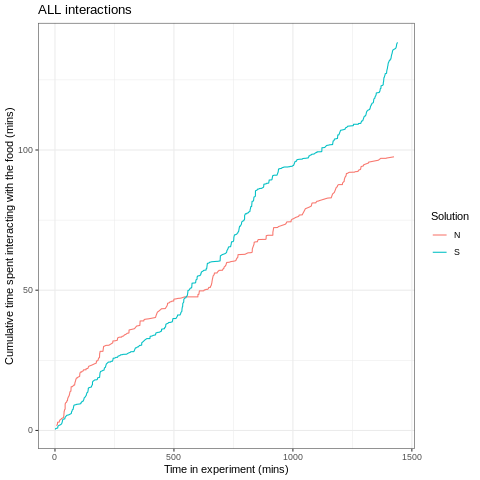

In [ ]:
%%R
ggplot(all_activity_data_cumulative_2minmax[which(all_activity_data_cumulative_2minmax$Treatment == "Suc_choice"),], aes(x = Time_min, y = Cumulative_Duration_overall, color = Solution)) +
  geom_line() +
  theme_bw() +
  ylab("Cumulative time spent interacting with the food (mins)") +
  xlab("Time in experiment (mins)") +
  ggtitle("ALL interactions")

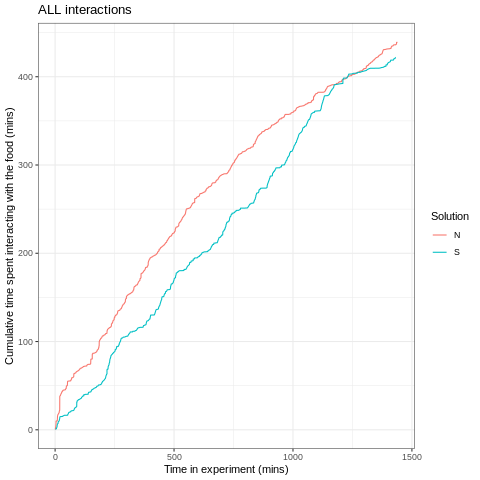

In [ ]:
%%R
ggplot(all_activity_data_cumulative[which(all_activity_data_cumulative$Treatment == "Nic_choice"),], aes(x = Time_min, y = Cumulative_Duration_overall, color = Solution)) +
  geom_line() +
  theme_bw() +
  ylab("Cumulative time spent interacting with the food (mins)") +
  xlab("Time in experiment (mins)") +
  ggtitle("ALL interactions")

##2. Cumulative time spent DRINKING each food source

### Extracting frames in which proboscis was in contact with food, and labelling the drinking bouts (max 1s between); merge with blinds

In [ ]:
%%R
#print(knitr::kable(ordered_activity_data[1:20,]))



| RPi|Tube |Behaviour |Time_in_experiment     | Frame| Tube_prob|  End_prob| Time_seconds|Clock_time              |Video | Round|Plot_time  | Num_time| Time_min|Activity_bout | mins_since_prev_frame|previous_activity | entry_ID|
|---:|:----|:---------|:----------------------|-----:|---------:|---------:|------------:|:-----------------------|:-----|-----:|:----------|--------:|--------:|:-------------|---------------------:|:-----------------|--------:|
|   2|left |Prob_out  |0 days 00:01:37        |     5| 0.0075222| 0.9936738|          1.0|2024-06-12 12:52:31.000 |0.0   |     1|00:01:37   |   1M 37S| 1.616667|Start_bout    |                    NA|NA                |        1|
|   2|left |Prob_out  |0 days 00:01:37.800000 |     9| 0.0037171| 0.6041908|          1.8|2024-06-12 12:52:31.800 |0.0   |     1|00:01:37.8 | 1M 37.8S| 1.630000|0             |             0.0133333|Start_bout        |        2|
|   2|left |Prob_out  |0 days 00:01:38        |    10| 0.0034131| 0.9753819|      

Subset drinking frames
Group appropriately and record lag time difference
If less than 5s, activity = mid bout

In [ ]:
%%R
print(knitr::kable(ordered_activity_data[1:20,]))



| Frame| Tube_prob_y| End_prob_y| Time_seconds|Time_in_experiment     |Clock_time              |Tube |RPi |Video                                                                  | Round| Tube_prob_likelihood| End_prob_likelihood|Behaviour    |Plot_time  | Num_time| Time_min| mins_since_prev_frame|Activity_bout |previous_activity |
|-----:|-----------:|----------:|------------:|:----------------------|:-----------------------|:----|:---|:----------------------------------------------------------------------|-----:|--------------------:|-------------------:|:------------|:----------|--------:|--------:|---------------------:|:-------------|:-----------------|
|     1|   181.99466|  184.34871|          0.2|0 days 00:03:44.200000 |2024-08-23 14:11:07.200 |left |1   |left_23-08-2024_14-11-07DLC_resnet50_Beecam_v4Jun25shuffle1_201000.csv |     1|            0.0040602|           0.9991578|Not drinking |00:03:44.2 | 3M 44.2S| 3.736667|             0.0033333|0             |Start_bout        |

In [ ]:
%%R
#Create new behaviour column. If tube_prob and end_prob >0.6, behaviour = 'drinking'
ordered_activity_data$Behaviour <- "Not drinking"
ordered_activity_data$Behaviour[ordered_activity_data$Tube_prob_likelihood > 0.6 & ordered_activity_data$End_prob_likelihood > 0.6] <- "Drinking"

In [ ]:
%%R
drinkingdata <- ordered_activity_data[which(ordered_activity_data$Behaviour=="Drinking"),] #Get frames of only bees feeding on the solution

In [ ]:
%%R
print(knitr::kable(drinkingdata[1:20,]))



| Frame| Tube_prob_y| End_prob_y| Time_seconds|Time_in_experiment     |Clock_time              |Tube  |RPi |Video                                                                   | Round| Tube_prob_likelihood| End_prob_likelihood|Behaviour |Plot_time  | Num_time| Time_min| mins_since_prev_frame|Activity_bout |previous_activity |
|-----:|-----------:|----------:|------------:|:----------------------|:-----------------------|:-----|:---|:-----------------------------------------------------------------------|-----:|--------------------:|-------------------:|:---------|:----------|--------:|--------:|---------------------:|:-------------|:-----------------|
|    21|    30.22504|   34.01084|          4.2|0 days 00:03:48.200000 |2024-08-23 14:11:11.200 |left  |1   |left_23-08-2024_14-11-07DLC_resnet50_Beecam_v4Jun25shuffle1_201000.csv  |     1|            0.6732330|           0.7012308|Drinking  |00:03:48.2 | 3M 48.2S| 3.803333|             0.0566667|0             |0                 |
| 

In [ ]:
%%R
print(knitr::kable(ordered_drinking_data[1:10,]))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  |  Num_time| Time_min|Treatment  |Pre_exposure |Solution |Mitigation_info | Cumulative_Duration| mins_since_prev_frame|Drinking_bout |previous_activity |
|:---|:----|-----:|----------------:|---------:|:----------|---------:|--------:|:----------|:------------|:--------|:---------------|-------------------:|---------------------:|:-------------|:-----------------|
|1   |L    |     1|               10| 0.0600000|00:18:14.2 | 18M 14.2S| 18.23667|Nic_choice |Nicotine     |S        |Alive           |           0.2433333|             0.0800000|0             |Start_bout        |
|1   |L    |     1|               11| 0.0100000|00:18:16   |   18M 16S| 18.26667|Nic_choice |Nicotine     |S        |Alive           |           0.2533333|             0.0300000|End_bout      |0                 |
|1   |R    |     1|               12| 0.0133333|00:18:30.8 | 18M 30.8S| 18.51333|Nic_choice |Nicotine     |N        |Alive           |           0

In [ ]:
%%R
# Arrange data and calculate time difference
ordered_drinking_data <- drinking_data %>%
    arrange(Round, RPi, Num_time) %>%
    group_by(RPi) %>%
    # Calculate time difference in minutes from the previous frame
    mutate(mins_since_prev_frame = Time_min - lag(Time_min),
           Drinking_bout = ifelse(is.na(mins_since_prev_frame) | mins_since_prev_frame > 0.083333, "Start_bout", "0")) %>%
    ungroup()

ordered_drinking_data <- ordered_drinking_data %>%
    group_by(RPi) %>%
    mutate(
        next_activity = lead(Drinking_bout),  # Check the next entry
        previous_activity = lag(Drinking_bout)
    ) %>%
    filter(
        !(Drinking_bout == "Start_bout" & previous_activity == "Start_bout" & is.na(next_activity)) |
        (Drinking_bout == "Start_bout" & next_activity != "End_bout")  # Retain only if followed by other frames
    ) %>%
    ungroup() %>%
    select(-previous_activity, -next_activity)  # Remove helper columns if no longer needed

# Add 'End_bout' labels before each new 'Start_bout' (while excluding the last row in each group to avoid overflow)
ordered_drinking_data <- ordered_drinking_data %>%
    group_by(RPi) %>%
    mutate(Drinking_bout = ifelse(lead(Drinking_bout) == "Start_bout", "End_bout", Drinking_bout)) %>%
    ungroup()

# Remove any stray 'Start_bout' entries at the end of each RPi's data
ordered_drinking_data <- ordered_drinking_data %>%
    group_by(RPi) %>%
    filter(!(row_number() == n() & Drinking_bout == "Start_bout")) %>%
    ungroup()

# Check counts of 'Start_bout' and 'End_bout' to verify they are balanced
table(ordered_drinking_data$Drinking_bout)


         0   End_bout Start_bout 
     30764       2593       1501 


In [ ]:
%%R
print(knitr::kable(ordered_drinking_data[1:20,]))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  |  Num_time| Time_min|Treatment  |Pre_exposure |Solution |Mitigation_info | Cumulative_Duration| mins_since_prev_frame|Drinking_bout |previous_activity |
|:---|:----|-----:|----------------:|---------:|:----------|---------:|--------:|:----------|:------------|:--------|:---------------|-------------------:|---------------------:|:-------------|:-----------------|
|1   |L    |     1|               10| 0.0600000|00:18:14.2 | 18M 14.2S| 18.23667|Nic_choice |Nicotine     |S        |Alive           |           0.2433333|             0.0800000|0             |Start_bout        |
|1   |L    |     1|               11| 0.0100000|00:18:16   |   18M 16S| 18.26667|Nic_choice |Nicotine     |S        |Alive           |           0.2533333|             0.0300000|End_bout      |0                 |
|1   |R    |     1|               12| 0.0133333|00:18:30.8 | 18M 30.8S| 18.51333|Nic_choice |Nicotine     |N        |Alive           |           0

In [ ]:
%%R
data_minuserror_bouts <- data_minuserror_end %>%
  mutate(Bout_no = cumsum(Activity_bout == "Start_bout"))

In [ ]:
%%R
drinkingdata$Drinking_bout <- 0
#Identify breaks in the time series (separate filming activity periods, each representative of general proboscis activity) and number them
  #Create a function that groups by RPi and loops through the plot times comparing to the previous.
  #If >5s between them, set new activity bout number
ordered_drinking_data <- drinkingdata %>%
    group_by(Round, RPi) %>%
    mutate(mins_since_prev_frame = Time_min - lag(Time_min)) %>%
#If difference > 0.016666 (greater than one second), label as start of new drinking bout (and label lag row as end)
    mutate(Drinking_bout = ifelse(mins_since_prev_frame > 0.016666, "Start_bout", "0"))

In [ ]:
%%R
#print(knitr::kable(ordered_drinking_data[1000:1100,]))

In [ ]:
%%R
#If new rpi, mins since prev frame will be negative
ordered_drinking_data$mins_since_prev_frame[ordered_drinking_data$mins_since_prev_frame < 0] <- NA #Change these to NAs
ordered_drinking_data[which(is.na(ordered_drinking_data$mins_since_prev_frame)),]$Drinking_bout <- "Start_bout" #Then change them to Start_bouts

In [ ]:
%%R
#If two consecutive 'Start_bout' when ordered appropriately, remove the one above (use lag function)
  #A single frame of proboscis action will have been an error
#i.e. if activity_bout = start_bout and lag activity_bout = start_bout, modify lag
ordered_drinking_data <- ordered_drinking_data %>%
  mutate(previous_activity = lag(Drinking_bout))

In [ ]:
%%R
head(ordered_drinking_data)

# A tibble: 6 × 20
# Groups:   Round, RPi [1]
  Frame Tube_prob_y End_prob_y Time_seconds Time_in_experiment  Clock_time Tube 
  <dbl>       <dbl>      <dbl>        <dbl> <chr>               <chr>      <chr>
1    21        30.2       34.0          4.2 0 days 00:03:48.20… 2024-08-2… left 
2    57       238.       260.          11.4 0 days 00:06:23.40… 2024-08-2… right
3    58       238.       275.          11.6 0 days 00:06:23.60… 2024-08-2… right
4    59       237.       273.          11.8 0 days 00:06:23.80… 2024-08-2… right
5    60       238.       274.          12   0 days 00:06:24     2024-08-2… right
6    61       237.       273.          12.2 0 days 00:06:24.20… 2024-08-2… right
# ℹ 13 more variables: RPi <fct>, Video <chr>, Round <int>,
#   Tube_prob_likelihood <dbl>, End_prob_likelihood <dbl>, Behaviour <chr>,
#   Plot_time <chr>, Num_time <Period>, Time_min <dbl>,
#   mins_since_prev_frame <dbl>, Activity_bout <chr>, previous_activity <chr>,
#   Drinking_bout <chr>


In [ ]:
%%R
#If both are start_bout, the row above is an error and can be removed (i.e. take one off the entry_ID and remove)
ordered_drinking_data$entry_ID <- 1:nrow(ordered_drinking_data)
error_frames <- ordered_drinking_data[which(ordered_drinking_data$Drinking_bout == "Start_bout" & ordered_drinking_data$previous_activity=="Start_bout"),]$entry_ID - 1
drinkingdata_minuserror <- ordered_drinking_data[!(ordered_drinking_data$entry_ID %in% error_frames),]

In [ ]:
%%R
#If the final entry of data_minuserror has an Activity_bout value of Start_bout, remove it
if (drinkingdata_minuserror[nrow(drinkingdata_minuserror),]$Drinking_bout == "Start_bout"){
  drinkingdata_minuserror <- drinkingdata_minuserror[-nrow(drinkingdata_minuserror),]
}

In [ ]:
%%R
#Check if all entries labelled as either start bout or 0
(nrow(drinkingdata_minuserror[which(drinkingdata_minuserror$Drinking_bout == "Start_bout"),])+ nrow(drinkingdata_minuserror[which(drinkingdata_minuserror$Drinking_bout == "0"),]) )/ nrow(drinkingdata_minuserror)

[1] 1


In [ ]:
%%R
# Add End_bout entries
drinkingdata_minuserror_end <- drinkingdata_minuserror %>%
  group_by(RPi) %>%
  mutate(
    Drinking_bout = ifelse(lead(Drinking_bout) == "Start_bout", "End_bout", Drinking_bout)
  ) %>%
  ungroup()

In [ ]:
%%R
nrow(drinkingdata_minuserror_end)

[1] 285204


In [ ]:
%%R
#Print only the rows which have an Activity_bout value of either Start_bout or End_bout
#print(knitr::kable(drinkingdata_minuserror_end[which(drinkingdata_minuserror_end$Drinking_bout == "Start_bout" | drinkingdata_minuserror_end$Drinking_bout == "End_bout"),]))

#print(knitr::kable(data_minuserror_end[73440:73446,]))

In [ ]:
%%R
nrow(drinkingdata_minuserror_end[which(drinkingdata_minuserror_end$Drinking_bout == "Start_bout"),])

[1] 39730


In [ ]:
%%R
nrow(drinkingdata_minuserror_end[which(drinkingdata_minuserror_end$Drinking_bout == "End_bout"),])

[1] 39729


In [ ]:
%%R
#If the final entry of data_minuserror has an Activity_bout value of Start_bout, remove it
if (drinkingdata_minuserror_end[nrow(drinkingdata_minuserror_end),]$Drinking_bout == "Start_bout"){
  drinkingdata_minuserror_end <- drinkingdata_minuserror_end[-nrow(drinkingdata_minuserror_end),]
}

#If the penultimate entry in the dataset has an Activity_bout value of "End_bout", remove the final entry
if (drinkingdata_minuserror_end[nrow(drinkingdata_minuserror_end)-1,]$Drinking_bout == "End_bout"){
  drinkingdata_minuserror_end <- drinkingdata_minuserror_end[-nrow(drinkingdata_minuserror_end),]
}

  missing value where TRUE/FALSE needed









Error in if (drinkingdata_minuserror_end[nrow(drinkingdata_minuserror_end),  : 
  missing value where TRUE/FALSE needed


In [ ]:
%%R
#Label the final entry as an End_bout
drinkingdata_minuserror_end[nrow(drinkingdata_minuserror_end),]$Drinking_bout <- "End_bout"

In [ ]:
%%R
print(knitr::kable(drinkingdata_minuserror_end[nrow(drinkingdata_minuserror_end),]))



| Frame| Tube_prob_y| End_prob_y| Time_seconds|Time_in_experiment       |Clock_time              |Tube  |RPi |Video                                                                   | Round| Tube_prob_likelihood| End_prob_likelihood|Behaviour |Plot_time |  Num_time| Time_min| mins_since_prev_frame|Activity_bout |previous_activity |Drinking_bout | entry_ID|
|-----:|-----------:|----------:|------------:|:------------------------|:-----------------------|:-----|:---|:-----------------------------------------------------------------------|-----:|--------------------:|-------------------:|:---------|:---------|---------:|--------:|---------------------:|:-------------|:-----------------|:-------------|--------:|
|   276|    197.2382|   218.5111|         55.2|-1 days +23:00:09.200000 |2024-09-06 16:50:00.200 |right |9   |right_06-09-2024_16-49-05DLC_resnet50_Beecam_v4Jun25shuffle1_186000.csv |    10|            0.9454964|            0.888487|Drinking  |+23:00:09 | 23H 0M 9S|  1380.15|    

In [ ]:
%%R
#Check there are equal numbers of bout start and end points
nrow(drinkingdata_minuserror_end[which(drinkingdata_minuserror_end$Drinking_bout == "Start_bout"),]) / nrow(drinkingdata_minuserror_end[which(drinkingdata_minuserror_end$Drinking_bout == "End_bout"),])

[1] 1


In [ ]:
%%R
drinkingdata_minuserror_bouts <- drinkingdata_minuserror_end %>%
  mutate(Drinking_bout_no = cumsum(Drinking_bout == "Start_bout"))

In [ ]:
%%R
# Calculate the duration of each drinking bout
All_drinking_bout_durations <- drinkingdata_minuserror_bouts %>%
  group_by(Drinking_bout_no) %>%
  dplyr::summarise(duration = max(Time_min) - min(Time_min)) %>%
  ungroup()

In [ ]:
%%R
#print(knitr::kable(All_activity_bout_durations))
seconds_feeding <- All_drinking_bout_durations$duration * 60

In [ ]:
%%R
nrow(drinkingdata_minuserror_bouts[which(drinkingdata_minuserror_bouts$Drinking_bout == "Start_bout"),])
#nrow(All_drinking_bout_durations)
#Both should have the same value

[1] 39730


In [ ]:
%%R
All_drinking_bout_durations$Tube <- drinkingdata_minuserror_bouts[which(drinkingdata_minuserror_bouts$Drinking_bout == "Start_bout"),]$Tube #Get the relevant tube information to add to the cumulative dataframe
All_drinking_bout_durations$Plot_time <- drinkingdata_minuserror_bouts[which(drinkingdata_minuserror_bouts$Drinking_bout == "End_bout"),]$Plot_time #Using this so can plot amount eaten after feeding
All_drinking_bout_durations$Num_time <- drinkingdata_minuserror_bouts[which(drinkingdata_minuserror_bouts$Drinking_bout == "End_bout"),]$Num_time
All_drinking_bout_durations$Time_min <- drinkingdata_minuserror_bouts[which(drinkingdata_minuserror_bouts$Drinking_bout == "End_bout"),]$Time_min
All_drinking_bout_durations$RPi <- drinkingdata_minuserror_bouts[which(drinkingdata_minuserror_bouts$Drinking_bout == "Start_bout"),]$RPi
All_drinking_bout_durations$Round <- drinkingdata_minuserror_bouts[which(drinkingdata_minuserror_bouts$Drinking_bout == "Start_bout"),]$Round

In [ ]:
%%R
All_drinking_bout_durations$Tube <- plyr::revalue(All_drinking_bout_durations$Tube, c("left" = "L", "right" = "R"))
head(All_drinking_bout_durations)

# A tibble: 6 × 8
  Drinking_bout_no duration Tube  Plot_time  Num_time  Time_min RPi   Round
             <int>    <dbl> <chr> <chr>      <Period>     <dbl> <fct> <int>
1                1   0.120  R     00:06:30.6 6M 30.6S      6.51 1         1
2                2   0.0100 L     00:12:26.4 12M 26.4S    12.4  1         1
3                3   0.0267 L     00:12:32   12M 32S      12.5  1         1
4                4   0.0500 R     00:13:40   13M 40S      13.7  1         1
5                5   0.0733 R     00:13:45.4 13M 45.4S    13.8  1         1
6                6   0.0467 R     00:13:52.4 13M 52.4S    13.9  1         1


Merge the blinds (mapping) data frame with All_drinking_bout_durations

In [ ]:
%%R
# Add an index column to the activity bout durations data to preserve the original order
All_drinking_bout_durations$index <- seq_len(nrow(All_drinking_bout_durations))
All_drinking_bout_durations_solution <- merge(All_drinking_bout_durations, ordered_blinds_mapping, by = c("RPi", "Tube", "Round"), all.x = TRUE)
All_drinking_bout_durations_solution <- All_drinking_bout_durations_solution[order(All_drinking_bout_durations_solution$index), ] # Re-order merged df to match the original order
All_drinking_bout_durations_solution$index <- NULL # Remove the index column bc no longer needed

head(All_drinking_bout_durations_solution)

    RPi Tube Round Drinking_bout_no   duration  Plot_time  Num_time Time_min
768   1    R     1                1 0.12000000 00:06:30.6  6M 30.6S  6.51000
57    1    L     1                2 0.01000000 00:12:26.4 12M 26.4S 12.44000
84    1    L     1                3 0.02666667   00:12:32   12M 32S 12.53333
827   1    R     1                4 0.05000000   00:13:40   13M 40S 13.66667
823   1    R     1                5 0.07333333 00:13:45.4 13M 45.4S 13.75667
820   1    R     1                6 0.04666667 00:13:52.4 13M 52.4S 13.87333
     Treatment Pre_exposure Solution Mitigation_info
768 Nic_choice     Nicotine        N           Alive
57  Nic_choice     Nicotine        S           Alive
84  Nic_choice     Nicotine        S           Alive
827 Nic_choice     Nicotine        N           Alive
823 Nic_choice     Nicotine        N           Alive
820 Nic_choice     Nicotine        N           Alive


In [ ]:
%%R
# Ensure the data is sorted correctly
drinking_data <- All_drinking_bout_durations_solution %>%
  arrange(Round, RPi)

#Subset only living bees and rpi != 8
drinking_data <- drinking_data[which(drinking_data$Mitigation_info == "Alive" & drinking_data$RPi != 8),]

# Compute cumulative duration within each RPi/Round/Solution group
drinking_data <- drinking_data %>%
  group_by(Treatment, Solution) %>%
  dplyr::mutate(Cumulative_Duration = cumsum(duration)) %>%
  ungroup()

In [ ]:
%%R
all_drinking_data_cumulative <- drinking_data %>%
  arrange(Num_time) %>%
  group_by(Treatment, Solution) %>%
  dplyr::mutate(Cumulative_Duration_overall = cumsum(duration)) %>%
  ungroup()

In [ ]:
%%R
all_drinking_data_cumulative_2minmax <- drinking_data[which(drinking_data$duration <2),] %>%
  arrange(Num_time) %>%
  group_by(Treatment, Solution) %>%
  dplyr::mutate(Cumulative_Duration_overall = cumsum(duration)) %>%
  ungroup()


all_drinking_data_cumulative_1minmax <- drinking_data[which(drinking_data$duration <1),] %>%
  arrange(Num_time) %>%
  group_by(Treatment, Solution) %>%
  dplyr::mutate(Cumulative_Duration_overall = cumsum(duration)) %>%
  ungroup()

all_drinking_data_cumulative_1sto1min <- drinking_data[which(drinking_data$duration < 1 & drinking_data$duration > 0.0166666),] %>%
  arrange(Num_time) %>%
  group_by(Treatment, Solution) %>%
  dplyr::mutate(Cumulative_Duration_overall = cumsum(duration)) %>%
  ungroup()

In [ ]:
%%R
#nrow(all_drinking_data_cumulative)
print(knitr::kable(all_drinking_data_cumulative[34500:34800,]))



|RPi |Tube | Round| Drinking_bout_no| duration|Plot_time |    Num_time| Time_min|Treatment    |Pre_exposure |Solution |Mitigation_info | Cumulative_Duration| Cumulative_Duration_overall|
|:---|:----|-----:|----------------:|--------:|:---------|-----------:|--------:|:------------|:------------|:--------|:---------------|-------------------:|---------------------------:|
|6   |L    |     5|            12569|        0|+23:37:30 | 23H 37M 30S| 1417.500|Nic_nochoice |Nicotine     |S2       |Alive           |           16.956667|                    56.12333|
|1   |R    |    10|            37545|        0|+23:37:30 | 23H 37M 30S| 1417.500|Nic_nochoice |Nicotine     |S1       |Alive           |           51.923333|                    63.75000|
|3   |R    |     3|             6202|        0|+23:37:31 | 23H 37M 31S| 1417.517|Nic_nochoice |Nicotine     |S2       |Alive           |            5.850000|                    56.12333|
|6   |L    |     5|            12570|        0|+23:37:31 | 23H 

## PLOT: Cumulative time spent drinking each solution

In [ ]:
%%R
ggplot(all_drinking_data_cumulative[which(all_drinking_data_cumulative$Treatment == "Nic_choice"),], aes(x = Time_min, y = Cumulative_Duration_overall, color = Solution))+
  geom_line() + theme_bw() + ylab("Cumulative time spent drinking the food (mins)") + xlab("Time in experiment (mins)") + ggtitle("Just proboscis contact with food")

^ Still doesn't look the same as in R - has something happened here?

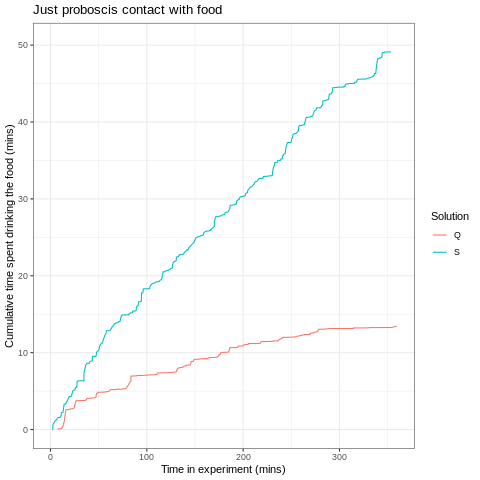

In [ ]:
%%R
ggplot(all_drinking_data_cumulative_1minmax, aes(x = Time_min, y = Cumulative_Duration_overall, color = Solution))+
  geom_line() + theme_bw() + ylab("Cumulative time spent drinking the food (mins)") + xlab("Time in experiment (mins)") + ggtitle("Just proboscis contact with food") + xlim(0, 360)

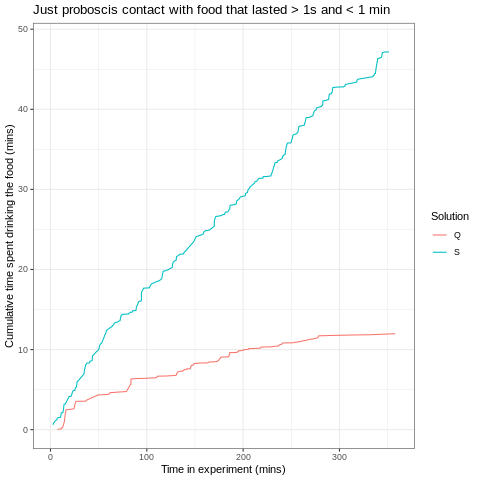

In [ ]:
%%R
ggplot(all_drinking_data_cumulative_1sto1min, aes(x = Time_min, y = Cumulative_Duration_overall, color = Solution))+
  geom_line() + theme_bw() + ylab("Cumulative time spent drinking the food (mins)") + xlab("Time in experiment (mins)") + ggtitle("Just proboscis contact with food that lasted > 1s and < 1 min") + xlim(0, 360)

---

In [ ]:
%%R
#Sample size
dplyr::n_distinct(all_drinking_data_cumulative$RPi, all_drinking_data_cumulative$Round)

[1] 26


## PLOT: Evolution of the preference index

### Preference index from weight measurements

In [ ]:
%%R
#Read in All_volumes.csv file from Quinine pilot folder
vol_data <- read.csv("/content/drive/My Drive/BeecamData/Quinine pilot/All_volumes.csv")

In [ ]:
%%R
head(vol_data)

  RPi Round Tube Choice_solution  Start    End Change Net_change         Net_PI
1   1     1    L               Q 3.7920 3.7675 0.0245    0.00905  0.07100591716
2   1     1    R               S 3.7879 3.7646 0.0233    0.00785 -0.07100591716
3   2     1    L               Q 3.7624 3.7225 0.0399    0.02445  -0.4707792208
4   2     1    R               S 3.7601 3.6767 0.0834    0.06795   0.4707792208
5   3     1    L               Q 3.7905 3.7559 0.0346    0.01915  -0.5139593909
6   3     1    R               S 3.7755 3.7004 0.0751    0.05965   0.5139593909
  Survival Other_mitigation Eaten..mg.
1    Alive          Escaped       9.05
2    Alive          Escaped       7.85
3    Alive                       24.45
4    Alive                       67.95
5    Alive                       19.15
6    Alive                       59.65


In [ ]:
%%R
library(dplyr)
library(tidyverse)
library(ggplot2)



(`geom_line()`). 

(`geom_line()`). 




Error in library(ggforce) : there is no package called ‘ggforce’


In [ ]:
%%R
nrow(vol_data[vol_data$Other_mitigation != "Escaped" & vol_data$Survival != "Dead" & vol_data$Choice_solution == "Q",])

[1] 38


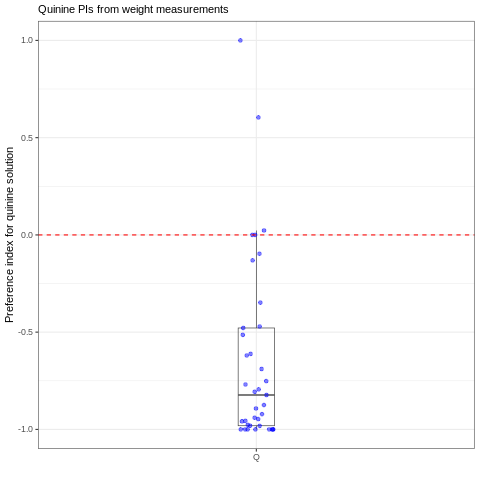

In [ ]:
%%R
# Filter the data
filtered_data <- vol_data[vol_data$Other_mitigation != "Escaped" & vol_data$Survival != "Dead" & vol_data$Choice_solution == "Q",]
filtered_data$Net_PI <- as.numeric(filtered_data$Net_PI)

# Create the plot
ggplot(filtered_data, aes(x = factor(Choice_solution), y = Net_PI)) +
  geom_boxplot(alpha = 0, width = 0.1, size = 0.3, position = position_dodge(0.8)) +  # Boxplot
  geom_jitter(width = 0.05, height = 0, alpha = 0.5, color = "blue") +  # Jittered points
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +  # Reference line
  theme_bw() +
  theme(plot.title = element_text(size = 11)) +
  ylab("Preference index for quinine solution") + xlab(" ") +
  ggtitle("Quinine PIs from weight measurements") +
  ylim(-1, 1)

In [ ]:
%%R
nrow(filtered_data)

[1] 38


### Preference index from cumulative time measurements

**Here, we want to order the drinking bouts by time in experiment and create a cumulative measure of how much had been drank of each solution at each time point**

In [ ]:
%%R
print(knitr::kable(all_drinking_data_cumulative[1:10,])) #Dataset with additive amount drank of each solution, used to make cumulative curves
#print(knitr::kable(all_drinking_data_cumulative[1:100,]))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  | Num_time| Time_min|Solution   | Cumulative_Duration| Cumulative_Duration_overall|
|:---|:----|-----:|----------------:|---------:|:----------|--------:|--------:|:----------|-------------------:|---------------------------:|
|10  |L    |     1|                1| 0.0066667|00:01:46   |   1M 46S| 1.766667|1M sucrose |           0.0066667|                   0.0066667|
|2   |R    |     4|              636| 0.0033333|00:02:16   |   2M 16S| 2.266667|1M sucrose |          40.8133333|                   0.0100000|
|7   |L    |     5|              971| 0.6066667|00:02:39.4 | 2M 39.4S| 2.656667|1M sucrose |          65.1066667|                   0.6166667|
|7   |L    |     5|              972| 0.0600000|00:02:45   |   2M 45S| 2.750000|1M sucrose |          65.1666667|                   0.6766667|
|10  |L    |     1|                2| 1.2033333|00:02:59.4 | 2M 59.4S| 2.990000|1M sucrose |           1.2100000|                   1.880000

Need to make a function that takes subsets of the drinking bout data (e.g. individual RPis at an individual round [one line]; individual RPis [number of round lines]; individual round [line for each RPi]) and iterates through each row to calculate a cumulative PI based on the given grouping variable (sol or tube)

In [ ]:
%%R
# Load necessary packages
library(ggplot2)
library(dplyr)

#all_drinking_data_cumulative_1sto1min$Solution <- plyr::revalue(all_drinking_data_cumulative_1sto1min$Solution, c("S" = "1M sucrose", "Q" = "1M sucrose + 0.1mM quinine"))
#all_drinking_data_cumulative$Solution <- plyr::revalue(all_drinking_data_cumulative$Solution, c("S" = "1M sucrose", "Q" = "1M sucrose + 0.1mM quinine"))

# Subset the data based on RPi and Round, then sort by Time_min
ordered_data <- all_drinking_data_cumulative %>%
  arrange(Time_min) # Sort by time in the experiment

# Initialize an empty dataframe to store the results
result_df <- data.frame()

# Get all unique combinations of RPi and Round
unique_combinations <- unique(ordered_data[c("RPi", "Round")])

# Iterate through each unique combination of RPi and Round, to subset those ordered rows
for (i in 1:nrow(unique_combinations)) {
  # Filter the data for each unique RPi and Round combination
  subset_filtered <- ordered_data %>%
    filter(RPi == unique_combinations$RPi[i] & Round == unique_combinations$Round[i])
  sol <- subset_filtered[i,]$Solution #Set local solution variable to S or Q
  time <- subset_filtered[i,]$Time_min
  print(sol, time)
}

# A tibble: 6 × 11
  RPi   Tube  Round Drinking_bout_no duration Plot_time  Num_time Time_min
  <fct> <chr> <int>            <int>    <dbl> <chr>      <Period>    <dbl>
1 10    L         1                1  0.00667 00:01:46   1M 46S       1.77
2 10    L         1                2  1.20    00:02:59.4 2M 59.4S     2.99
3 10    L         1                3  0.00333 00:03:33.8 3M 33.8S     3.56
4 10    L         1                4  0.107   00:03:41.4 3M 41.4S     3.69
5 10    L         1                5  0.00667 00:03:44.4 3M 44.4S     3.74
6 10    L         1                6  0.0100  00:03:46   3M 46S       3.77
# ℹ 3 more variables: Solution <chr>, Cumulative_Duration <dbl>,
#   Cumulative_Duration_overall <dbl>
# A tibble: 6 × 11
  RPi   Tube  Round Drinking_bout_no duration Plot_time  Num_time Time_min
  <fct> <chr> <int>            <int>    <dbl> <chr>      <Period>    <dbl>
1 2     R         4              636  0.00333 00:02:16   2M 16S       2.27
2 2     R         4              6

In [ ]:
%%R
# Iterate through each unique combination of RPi and Round
result_df <- list() # Initialize a list to store the results for each combination

for (j in 1:nrow(unique_combinations)) {
  # Filter the data for each unique RPi and Round combination
  subset_filtered <- ordered_data %>%
    filter(RPi == unique_combinations$RPi[j] & Round == unique_combinations$Round[j])

  # Make a cumulative duration measure
  subset_filtered <- subset_filtered %>%
    group_by(Solution) %>%
    dplyr::mutate(Cumulative_Duration = cumsum(duration)) %>%
    ungroup() %>%
    arrange(Time_min) # Ensure it is ordered by time

  # Initialize a column for Cumulative_PI
  subset_filtered$Cumulative_PI <- NA

  # Calculate Preference Index (PI) over time for each row in the subset
  for (k in 1:nrow(subset_filtered)){ # For each row in the dataset of cumulative feeding time
    sol <- subset_filtered[k,]$Solution # Set local solution variable to S or Q
    time <- subset_filtered[k,]$Time_min
    cumulative <- subset_filtered[k,]$Cumulative_Duration
    Q_cumul <- 0
    S_cumul <- 0

    # If sucrose entry, get closest recent quinine entry
    if (sol == "1M sucrose"){
      S_cumul <- cumulative
      other_solution_time <- max(subset_filtered[which(subset_filtered$Solution == "1M sucrose + 0.1mM quinine" & subset_filtered$Time_min <= time),]$Time_min, na.rm = TRUE)
      other_solution_cumulative <- max(subset_filtered[which(subset_filtered$Solution == "1M sucrose + 0.1mM quinine" & subset_filtered$Time_min <= time),]$Cumulative_Duration, na.rm = TRUE)

      if (is.finite(other_solution_time)){
        Q_cumul <- other_solution_cumulative
      }
    }

    # If quinine entry, get closest recent sucrose entry
    if (sol == "1M sucrose + 0.1mM quinine"){
      Q_cumul <- cumulative
      other_solution_time <- max(subset_filtered[which(subset_filtered$Solution == "1M sucrose" & subset_filtered$Time_min <= time),]$Time_min, na.rm = TRUE)
      other_solution_cumulative <- max(subset_filtered[which(subset_filtered$Solution == "1M sucrose" & subset_filtered$Time_min <= time),]$Cumulative_Duration, na.rm = TRUE)

      if (is.finite(other_solution_time)){
        S_cumul <- other_solution_cumulative
      }
    }

    # Calculate Cumulative_PI (add a check to avoid division by zero)
    if (Q_cumul + S_cumul > 0) {
      subset_filtered[k,]$Cumulative_PI <- (Q_cumul - S_cumul) / (Q_cumul + S_cumul)
    } else {
      subset_filtered[k,]$Cumulative_PI <- NA  # Set NA if there's no valid comparison
    }
  }

  # Append the results to the result list
  result_df[[paste(unique_combinations$RPi[j], unique_combinations$Round[j], sep = "_")]] <- subset_filtered
}

# Combine all the results into a single data frame
final_result <- bind_rows(result_df)


In [ ]:
%%R
#Check that this is working
head(final_result)

# A tibble: 6 × 12
  RPi   Tube  Round Drinking_bout_no duration Plot_time  Num_time Time_min
  <fct> <chr> <int>            <int>    <dbl> <chr>      <Period>    <dbl>
1 10    L         1                1  0.00667 00:01:46   1M 46S       1.77
2 10    L         1                2  1.20    00:02:59.4 2M 59.4S     2.99
3 10    L         1                3  0.00333 00:03:33.8 3M 33.8S     3.56
4 10    L         1                4  0.107   00:03:41.4 3M 41.4S     3.69
5 10    L         1                5  0.00667 00:03:44.4 3M 44.4S     3.74
6 10    L         1                6  0.0100  00:03:46   3M 46S       3.77
# ℹ 4 more variables: Solution <chr>, Cumulative_Duration <dbl>,
#   Cumulative_Duration_overall <dbl>, Cumulative_PI <dbl>


In [ ]:
%%R
# Plot the results
ggplot(final_result, aes(x = Time_min, y = Cumulative_PI, color = interaction(RPi, Round))) +
  geom_line() + geom_hline(yintercept = 0, linetype = "dashed") +  # Reference line
  labs(title = "Cumulative Preference Index over Time by RPi and Round",
       x = "Time in Experiment (minutes)",
       y = "Preference Index (PI)") +
  theme_minimal()

In [ ]:
%%R
head(final_result)

# A tibble: 6 × 12
  RPi   Tube  Round Drinking_bout_no duration Plot_time  Num_time Time_min
  <fct> <chr> <int>            <int>    <dbl> <chr>      <Period>    <dbl>
1 10    L         1                1  0.00667 00:01:46   1M 46S       1.77
2 10    L         1                2  1.20    00:02:59.4 2M 59.4S     2.99
3 10    L         1                3  0.00333 00:03:33.8 3M 33.8S     3.56
4 10    L         1                4  0.107   00:03:41.4 3M 41.4S     3.69
5 10    L         1                5  0.00667 00:03:44.4 3M 44.4S     3.74
6 10    L         1                6  0.0100  00:03:46   3M 46S       3.77
# ℹ 4 more variables: Solution <chr>, Cumulative_Duration <dbl>,
#   Cumulative_Duration_overall <dbl>, Cumulative_PI <dbl>


In [ ]:
%%R
end_PIs_beecam <- list() # Initialize a list to store the results for each combination

final_result$Time_min <- as.numeric(final_result$Time_min)  # Ensure Time_min is numeric

for (k in 1:nrow(unique_combinations)) {
  # Filter the data for each unique RPi and Round combination
  subset_filtered <- final_result %>%
    filter(RPi == unique_combinations$RPi[k] & Round == unique_combinations$Round[k])

  # Get the row where Time_min is maximum
  max_time_row <- which.max(subset_filtered$Time_min)

  # Extract the corresponding Cumulative_PI from that row
  end_PI <- subset_filtered$Cumulative_PI[max_time_row]

  # Store the result in the list
  end_PIs_beecam[[k]] <- end_PI
}

# Output the result
end_PIs_beecam


[[1]]
[1] -0.8670837

[[2]]
[1] -0.9958391

[[3]]
[1] -0.8879433

[[4]]
[1] -0.9084605

[[5]]
[1] NA

[[6]]
[1] -0.9816373

[[7]]
[1] -0.7901172

[[8]]
[1] -0.673913

[[9]]
[1] 0.07545533

[[10]]
[1] -0.4017094

[[11]]
[1] -0.7615298

[[12]]
[1] -0.5317378

[[13]]
[1] -0.8029711

[[14]]
[1] -0.9983987

[[15]]
[1] 0.07355517

[[16]]
[1] -1

[[17]]
[1] -1

[[18]]
[1] -0.9707317

[[19]]
[1] -0.5815603

[[20]]
[1] 0.1360875

[[21]]
[1] 0.4798206

[[22]]
[1] 0.2474227

[[23]]
[1] 0.8402367

[[24]]
[1] -0.8272727

[[25]]
[1] -1

[[26]]
[1] -0.9465812



In [ ]:
%%R
end_PIs_df

            PI
1  -0.86708366
2  -0.99583911
3  -0.88794326
4  -0.90846047
5           NA
6  -0.98163734
7  -0.79011717
8  -0.67391304
9   0.07545533
10 -0.40170940
11 -0.76152981
12 -0.53173777
13 -0.80297107
14 -0.99839872
15  0.07355517
16 -1.00000000
17 -1.00000000
18 -0.97073171
19 -0.58156028
20  0.13608748
21  0.47982063
22  0.24742268
23  0.84023669
24 -0.82727273
25 -1.00000000
26 -0.94658120


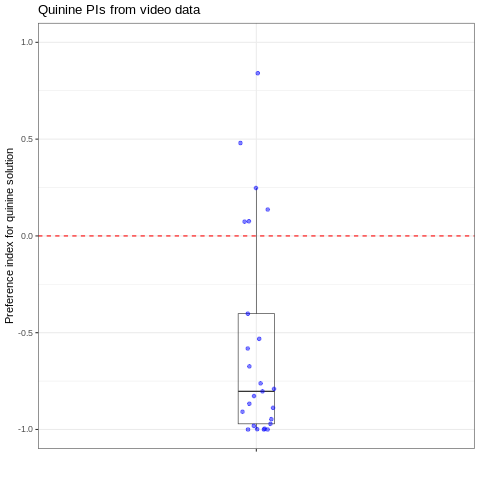

In [ ]:
%%R
# Load necessary library
library(ggplot2)

# Assuming 'end_PIs_beecam' is a list, convert it to a data frame for plotting
end_PIs_df <- data.frame(PI = unlist(end_PIs_beecam))

# Create the boxplot with jitter
ggplot(end_PIs_df, aes(x = "", y = PI)) +
  geom_boxplot(alpha = 0, width = 0.1, size = 0.3, position = position_dodge(0.8)) +  # Boxplot
  geom_jitter(width = 0.05, height = 0, alpha = 0.5, color = "blue") +  # Jittered points
  ylim(c(-1, 1)) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") +  # Reference line # Set y-axis limits
  labs(y = "Preference index for quinine solution", x = "") +  # Label the axes
  theme_bw() +ggtitle("Quinine PIs from video data") # Use a clean theme

In [ ]:
%%R
# Iterate through each unique combination of RPi and Round, to subset those ordered rows
for (i in 1:nrow(unique_combinations)) {
  # Filter the data for each unique RPi and Round combination
  subset_filtered <- ordered_data %>%
    filter(RPi == unique_combinations$RPi[i] & Round == unique_combinations$Round[i])
  #Make a cumulative duration measure
  subset_filtered <- subset_filtered %>%
  group_by(Solution) %>%
  dplyr::mutate(Cumulative_Duration = cumsum(duration)) %>%
  ungroup()
  subset_filtered %>%
  arrange(Time_min)
  # Calculate Preference Index (PI) over time for each row in the subset
  for (i in 1:nrow(subset_filtered)){ #For each row in the dataset of cumulative feeding time
    sol <- subset_filtered[i,]$Solution #Set local solution variable to S or Q
    time <- subset_filtered[i,]$Time_min
    cumulative <- subset_filtered[i,]$Cumulative_Duration
    Q_cumul <- 0
    S_cumul <- 0
    #If sucrose entry, get closest recent quinine entry
    if (sol == "1M sucrose"){
      S_cumul <- cumulative
      Q_cumul <- 0
      other_solution_time <- max(subset_filtered[which(subset_filtered$Solution == "1M sucrose + 0.1mM quinine" & subset_filtered$Time_min <= time),]$Time_min)
      other_solution_cumulative <- max(subset_filtered[which(subset_filtered$Solution == "1M sucrose + 0.1mM quinine" & subset_filtered$Time_min <= time),]$Cumulative_Duration)
      if (is.finite(other_solution_time)){
        Q_cumul <- other_solution_cumulative
        }
      }
    if (sol == "1M sucrose + 0.1mM quinine"){
      Q_cumul <- cumulative
      S_cumul <- 0
      other_solution_time <- max(subset_filtered[which(subset_filtered$Solution == "1M sucrose" & subset_filtered$Time_min <= time),]$Time_min)
      other_solution_cumulative <- max(subset_filtered[which(subset_filtered$Solution == "1M sucrose" & subset_filtered$Time_min <= time),]$Cumulative_Duration)
      if (is.finite(other_solution_time)){
        S_cumul <- other_solution_cumulative
        }
      }
    subset_filtered[i,]$Cumulative_PI <- (Q_cumul - S_cumul) / (Q_cumul + S_cumul)
  }
  result_df <- bind_rows(subset_filtered)
}

Error in `[<-`:
! Can't recycle input of size 12 to size 11.
Run `rlang::last_trace()` to see where the error occurred.



Error in `[<-`(`*tmp*`, i, , value = list(RPi = 2L, Tube = "L", Round = 1L,  :


In [ ]:
%%R
head(result_df)

data frame with 0 columns and 0 rows


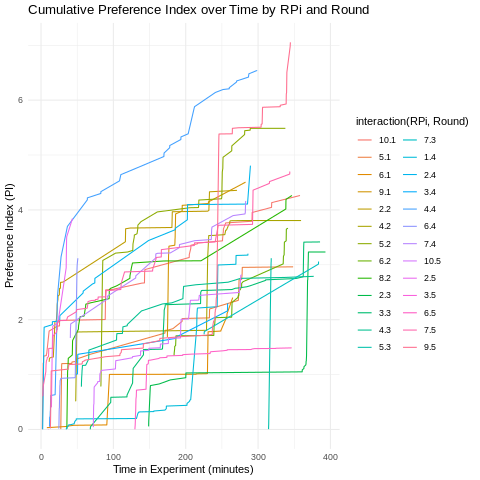

In [ ]:
%%R
# Load necessary packages
library(ggplot2)
library(dplyr)

# Define the cumulative PI function with subsetting by both RPi and Round
cumulative_PI <- function(data, focal_var) {

  # Subset the data based on RPi and Round, then sort by Time_min
  subset_data <- data %>%
    arrange(Time_min) # Sort by time in the experiment

  # Initialise an empty list to store the results
  PI_list <- list()

  # Get all unique combinations of RPi and Round
  unique_combinations <- unique(subset_data[c("RPi", "Round")])

  # Iterate through each unique combination of RPi and Round
  for (i in 1:nrow(unique_combinations)) {
    # Filter the data for each unique RPi and Round combination
    subset_filtered <- subset_data %>%
      filter(RPi == unique_combinations$RPi[i] & Round == unique_combinations$Round[i])

    # Calculate cumulative duration for both the current and the other group
    cumulative_df <- subset_filtered %>%
      group_by(!!as.name(focal_var)) %>%
      mutate(
        cumulative_duration = cumsum(duration)
      )

    # Calculate Preference Index (PI) over time
    cumulative_df <- cumulative_df %>%
      mutate(
        PI = cumulative_duration #- other_cumulative_duration) /
         #     (cumulative_duration + other_cumulative_duration)
      )

    # Store the results for this subset
    PI_list[[paste(unique_combinations$RPi[i], unique_combinations$Round[i], sep = "_")]] <- cumulative_df
  }

  # Combine all the results into a single data frame
  result_df <- bind_rows(PI_list)

  # Return the result
  return(result_df)
}

result_data <- cumulative_PI(data = all_drinking_data_cumulative, focal_var = "Solution")

# Plot the results
ggplot(result_data, aes(x = Time_min, y = PI, color = interaction(RPi, Round))) +
  geom_line() +
  labs(title = "Cumulative Preference Index over Time by RPi and Round",
       x = "Time in Experiment (minutes)",
       y = "Preference Index (PI)") +
  theme_minimal()


In [ ]:
%%R
#nrow(all_drinking_data_cumulative)
print(knitr::kable(all_drinking_data_cumulative[1:50,]))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  |  Num_time|  Time_min|Solution | Cumulative_Duration| Cumulative_Duration_overall|
|:---|:----|-----:|----------------:|---------:|:----------|---------:|---------:|:--------|-------------------:|---------------------------:|
|10  |L    |     1|                1| 0.0066667|00:01:46   |    1M 46S|  1.766667|S        |           0.0066667|                   0.0066667|
|2   |R    |     4|              636| 0.0033333|00:02:16   |    2M 16S|  2.266667|S        |          40.8133333|                   0.0100000|
|7   |L    |     5|              971| 0.6066667|00:02:39.4 |  2M 39.4S|  2.656667|S        |          65.1066667|                   0.6166667|
|7   |L    |     5|              972| 0.0600000|00:02:45   |    2M 45S|  2.750000|S        |          65.1666667|                   0.6766667|
|10  |L    |     1|                2| 1.2033333|00:02:59.4 |  2M 59.4S|  2.990000|S        |           1.2100000|                   1.880000

The following code will take the full dataframe as it is and plot the overall cumulative PI:

In [ ]:
%%R
all_drinking_data_cumulative_1sto1min$Solution <- plyr::revalue(all_drinking_data_cumulative_1sto1min$Solution, c("S" = "1M sucrose", "Q" = "1M sucrose + 0.1mM quinine"))

#For each row:
  # Determine the solution
    # If sucrose, set local variable to S
    # Else, set local solution variable to Q
  # Read the time_min value of the row and set it to start value
  # If solution == "S":
    # Are there any quinine rows with a time_min value equal to or lower than this?
    # If so:
      # Find the max value of these and set to local max_other_value
    # If not:
      # Set other solution time_min value to 0
  # Else, check for sucrose rows and find the max value of them
  # Calculate PI using these values

data_to_plot <- all_drinking_data_cumulative_1sto1min
#data_to_plot <- data_to_plot[order(data_to_plot$Time_min),]
data_to_plot$Cumulative_PI <- 0

for (i in 1:nrow(data_to_plot)){ #For each row in the dataset of cumulative feeding time
  sol <- data_to_plot[i,]$Solution #Set local solution variable to S or Q
  time <- data_to_plot[i,]$Time_min
  cumulative <- data_to_plot[i,]$Cumulative_Duration_overall
  Q_cumul <- 0
  S_cumul <- 0
  #If sucrose entry, get closest recent quinine entry
  if (sol == "1M sucrose"){
    S_cumul <- cumulative
    Q_cumul <- 0
    other_solution_time <- max(data_to_plot[which(data_to_plot$Solution == "1M sucrose + 0.1mM quinine" & data_to_plot$Time_min <= time),]$Time_min)
    other_solution_cumulative <- max(data_to_plot[which(data_to_plot$Solution == "1M sucrose + 0.1mM quinine" & data_to_plot$Time_min <= time),]$Cumulative_Duration_overall)
    if (is.finite(other_solution_time)){
      Q_cumul <- other_solution_cumulative
      }
    }
  if (sol == "1M sucrose + 0.1mM quinine"){
    Q_cumul <- cumulative
    S_cumul <- 0
    other_solution_time <- max(data_to_plot[which(data_to_plot$Solution == "1M sucrose" & data_to_plot$Time_min <= time),]$Time_min)
    other_solution_cumulative <- max(data_to_plot[which(data_to_plot$Solution == "1M sucrose" & data_to_plot$Time_min <= time),]$Cumulative_Duration_overall)
    if (is.finite(other_solution_time)){
      S_cumul <- other_solution_cumulative
      }
    }
  data_to_plot[i,]$Cumulative_PI <- (Q_cumul - S_cumul) / (Q_cumul + S_cumul)
}

#Insert an entry of PI 0 at time 0
data_to_plot[nrow(data_to_plot) + 1,]$Time_min <- 0
data_to_plot[nrow(data_to_plot),]$Cumulative_PI <- 0

In [ ]:
%%R
#data_to_plot$Cumulative_PI

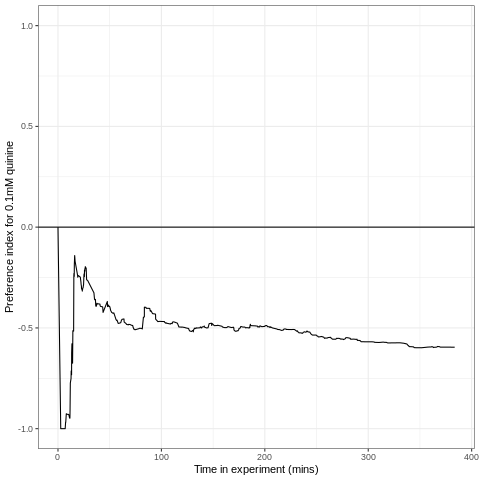

In [ ]:
%%R
PI_evolution_plot <- ggplot(data_to_plot, aes(x = Time_min, y = Cumulative_PI))+
  geom_line() + theme_bw() + ylab("Preference index for 0.1mM quinine") + xlab("Time in experiment (mins)") + ylim(c(-1, 1)) + geom_hline(yintercept=0)
PI_evolution_plot

In [ ]:
%%R
print(knitr::kable(data_to_plot[which(data_to_plot$Solution == "1M sucrose + 0.1mM quinine"),]))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  |     Num_time|   Time_min|Solution                   | Cumulative_Duration| Cumulative_Duration_overall| Cumulative_PI|
|:---|:----|-----:|----------------:|---------:|:----------|------------:|----------:|:--------------------------|-------------------:|---------------------------:|-------------:|
|10  |R    |     1|                8| 0.0233333|00:07:22.2 |     7M 22.2S|   7.370000|1M sucrose + 0.1mM quinine |           0.0333333|                   0.0233333|    -0.9672897|
|6   |L    |     1|              101| 0.0333333|00:08:02   |        8M 2S|   8.033333|1M sucrose + 0.1mM quinine |           0.6700000|                   0.0566667|    -0.9257642|
|4   |R    |     4|              675| 0.0500000|00:11:41   |      11M 41S|  11.683333|1M sucrose + 0.1mM quinine |          13.7900000|                   0.1066667|    -0.9039039|
|4   |R    |     4|              676| 0.0333333|00:11:44   |      11M 44S|  11.733333|1M sucrose +

In [ ]:
%%R
0.0233333-(0.6066667+0.0600000+0.1233333+0.1066667+0.0733333+0.0366667+0.2633333+0.1333333+0.0666667)/(0.0233333 + 1.403333+0.0666667)

[1] -0.9610419


In [ ]:
%%R
0.0233333-(0.6066667+0.0600000+0.1233333+0.1066667+0.0733333+0.0366667+0.2633333+0.1333333)/(0.0233333 + 0.6066667+0.0600000+0.1233333+0.1066667+0.0733333+0.0366667+0.2633333+0.1333333)

[1] -0.9603116


## Adapting it to make a multipurpose PI function

takes subsets of the drinking bout data (e.g. individual RPis at an individual round [one line]; individual RPis [number of round lines]; individual round [line for each RPi]) and iterates through each row to calculate a cumulative PI based on the given grouping variable (sol or tube)

In [ ]:
# Define a function that takes a grouping variable (either 'sol' or 'tube')
# If sol, subset the data by the subsetting variable(s). For each value/combination, iterate over the times of feeding bouts and calculate PI by the input group
#



all_drinking_data_cumulative_1sto1min$Solution <- plyr::revalue(all_drinking_data_cumulative_1sto1min$Solution, c("S" = "1M sucrose", "Q" = "1M sucrose + 0.1mM quinine"))

#For each row:
  # Determine the solution
    # If sucrose, set local variable to S
    # Else, set local solution variable to Q
  # Read the time_min value of the row and set it to start value
  # If solution == "S":
    # Are there any quinine rows with a time_min value equal to or lower than this?
    # If so:
      # Find the max value of these and set to local max_other_value
    # If not:
      # Set other solution time_min value to 0
  # Else, check for sucrose rows and find the max value of them
  # Calculate PI using these values

data_to_plot <- all_drinking_data_cumulative_1sto1min
#data_to_plot <- data_to_plot[order(data_to_plot$Time_min),]
data_to_plot$Cumulative_PI <- 0

for (i in 1:nrow(data_to_plot)){ #For each row in the dataset of cumulative feeding time
  sol <- data_to_plot[i,]$Solution #Set local solution variable to S or Q
  time <- data_to_plot[i,]$Time_min
  cumulative <- data_to_plot[i,]$Cumulative_Duration_overall
  Q_cumul <- 0
  S_cumul <- 0
  #If sucrose entry, get closest recent quinine entry
  if (sol == "1M sucrose"){
    S_cumul <- cumulative
    Q_cumul <- 0
    other_solution_time <- max(data_to_plot[which(data_to_plot$Solution == "1M sucrose + 0.1mM quinine" & data_to_plot$Time_min <= time),]$Time_min)
    other_solution_cumulative <- max(data_to_plot[which(data_to_plot$Solution == "1M sucrose + 0.1mM quinine" & data_to_plot$Time_min <= time),]$Cumulative_Duration_overall)
    if (is.finite(other_solution_time)){
      Q_cumul <- other_solution_cumulative
      }
    }
  if (sol == "1M sucrose + 0.1mM quinine"){
    Q_cumul <- cumulative
    S_cumul <- 0
    other_solution_time <- max(data_to_plot[which(data_to_plot$Solution == "1M sucrose" & data_to_plot$Time_min <= time),]$Time_min)
    other_solution_cumulative <- max(data_to_plot[which(data_to_plot$Solution == "1M sucrose" & data_to_plot$Time_min <= time),]$Cumulative_Duration_overall)
    if (is.finite(other_solution_time)){
      S_cumul <- other_solution_cumulative
      }
    }
  data_to_plot[i,]$Cumulative_PI <- (Q_cumul - S_cumul) / (Q_cumul + S_cumul)
}

#Insert an entry of PI 0 at time 0
data_to_plot[nrow(data_to_plot) + 1,]$Time_min <- 0
data_to_plot[nrow(data_to_plot),]$Cumulative_PI <- 0

## PLOT: Preference indices of individual bees over time

In [ ]:
%%R
head(drinking_data)
#Assign an individual bee number which increases by 1 for each unique combination of the RPi and Round variables

# Combine the two variables into a unique identifier
drinking_data$unique_combination <- paste(drinking_data$RPi, drinking_data$Round, sep = "_")
# Generate a numeric ID for each unique combination
drinking_data$ID <- as.integer(factor(drinking_data$unique_combination))
# Drop the intermediate unique_combination column if no longer needed
drinking_data$unique_combination <- NULL



In [ ]:
%%R
print(knitr::kable(data_to_plot_indiv[1:6,]))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  | Num_time| Time_min|Solution   | Cumulative_Duration|ID | Cumulative_Duration_bybee| Cumulative_PI|
|:---|:----|-----:|----------------:|---------:|:----------|--------:|--------:|:----------|-------------------:|:--|-------------------------:|-------------:|
|10  |L    |     1|                1| 0.0066667|00:01:46   |   1M 46S| 1.766667|1M sucrose |           0.0066667|2  |                 0.0066667|            -1|
|2   |R    |     4|              636| 0.0033333|00:02:16   |   2M 16S| 2.266667|1M sucrose |          40.8133333|6  |                 0.0033333|            -1|
|7   |L    |     5|              971| 0.6066667|00:02:39.4 | 2M 39.4S| 2.656667|1M sucrose |          65.1066667|23 |                 0.6066667|            -1|
|7   |L    |     5|              972| 0.0600000|00:02:45   |   2M 45S| 2.750000|1M sucrose |          65.1666667|23 |                 0.6666667|            -1|
|10  |L    |     1|                2| 

In [ ]:
%%R
all_drinking_data_cumulative_byindividual <- drinking_data %>%
  arrange(Num_time) %>%
  group_by(Solution, ID) %>%
  dplyr::mutate(Cumulative_Duration_bybee = cumsum(duration)) %>%
  ungroup()

In [ ]:
%%R
head(data_to_plot_indiv)$Solution

[1] "1M sucrose" "1M sucrose" "1M sucrose" "1M sucrose" "1M sucrose"
[6] "1M sucrose"


>> <<

In [ ]:
%%R
# Initialize an empty list to store results
result_list <- list()

# Get unique individual IDs
unique_individuals <- unique(data_to_plot_indiv$ID)

# Loop through each unique individual ID
for (ind_id in unique_individuals) {
  # Subset data for the current individual
  ind_data <- filter(data_to_plot_indiv, ID == ind_id)

  # Initialize cumulative variables
  ind_data <- ind_data %>%
    arrange(Time_min) %>%
    mutate(
      S_cumul = if_else(Solution == "1M sucrose", Cumulative_Duration_bybee, 0),
      Q_cumul = if_else(Solution == "1M sucrose + 0.1mM quinine", Cumulative_Duration_bybee, 0)
    ) %>%
    mutate(
      S_cumul = cumsum(S_cumul),
      Q_cumul = cumsum(Q_cumul)
    ) %>%
    mutate(
      Cumulative_PI = (Q_cumul - S_cumul) / (Q_cumul + S_cumul)
    )

  # Add the processed data for this individual to the result list
  result_list[[ind_id]] <- ind_data
}

# Combine all individual results into a single dataframe
final_result <- bind_rows(result_list)

# Print the updated dataframe
print(final_result)

In [ ]:
%%R
all_drinking_data_cumulative_byindividual$Solution <- plyr::revalue(all_drinking_data_cumulative_byindividual$Solution, c("S" = "1M sucrose", "Q" = "1M sucrose + 0.1mM quinine"))
data_to_plot_indiv <- all_drinking_data_cumulative_byindividual

# Initialize Cumulative_PI column
data_to_plot_indiv$Cumulative_indiv_PI <- 0

# Get unique individual IDs
unique_individuals <- unique(data_to_plot_indiv$ID)

# Outer loop for each individual
for (ind_id in unique_individuals) {

  # Subset data for the current individual
  data_individual <- data_to_plot_indiv %>% filter(ID == ind_id)

  # Ensure data is ordered by Time_min
  data_individual <- data_individual %>% arrange(Time_min)

  # Process each row within the current individual
  for (i in 1:nrow(data_individual)) {
    sol <- data_individual[i,]$Solution # Set local solution variable to S or Q
    time <- data_individual[i,]$Time_min
    cumulative <- data_individual[i,]$Cumulative_Duration_bybee
    Q_cumul <- 0
    S_cumul <- 0

    # If sucrose entry, get closest recent quinine entry
    if (sol == "1M sucrose") {
      S_cumul <- cumulative
      other_solution_time <- max(data_individual[which(data_individual$Solution == "1M sucrose + 0.1mM quinine" & data_individual$Time_min <= time),]$Time_min, na.rm = TRUE)
      other_solution_cumulative <- max(data_individual[which(data_individual$Solution == "1M sucrose + 0.1mM quinine" & data_individual$Time_min <= time),]$Cumulative_Duration_overall, na.rm = TRUE)
      if (is.finite(other_solution_time)) {
        Q_cumul <- other_solution_cumulative
      }
    }

    if (sol == "1M sucrose + 0.1mM quinine") {
      Q_cumul <- cumulative
      other_solution_time <- max(data_individual[which(data_individual$Solution == "1M sucrose" & data_individual$Time_min <= time),]$Time_min, na.rm = TRUE)
      other_solution_cumulative <- max(data_individual[which(data_individual$Solution == "1M sucrose" & data_individual$Time_min <= time),]$Cumulative_Duration_overall, na.rm = TRUE)
      if (is.finite(other_solution_time)) {
        S_cumul <- other_solution_cumulative
      }
    }

    print(data_individual)
    # Update Cumulative_indiv_PI in the subset dataframe
    data_individual[i, "Cumulative_indiv_PI"] <- (Q_cumul - S_cumul) / (Q_cumul + S_cumul)
  }

  # Update the main dataframe with results from this individual
  data_to_plot_indiv[data_to_plot_indiv$ID == ind_id, "Cumulative_indiv_PI"] <- data_to_plot_indiv$Cumulative_indiv_PI
}


# A tibble: 52 × 13
   RPi   Tube  Round Drinking_bout_no duration Plot_time  Num_time  Time_min
   <fct> <chr> <int>            <int>    <dbl> <chr>      <Period>     <dbl>
 1 10    L         1                1  0.00667 00:01:46   1M 46S        1.77
 2 10    L         1                2  1.20    00:02:59.4 2M 59.4S      2.99
 3 10    L         1                3  0.00333 00:03:33.8 3M 33.8S      3.56
 4 10    L         1                4  0.107   00:03:41.4 3M 41.4S      3.69
 5 10    L         1                5  0.00667 00:03:44.4 3M 44.4S      3.74
 6 10    L         1                6  0.0100  00:03:46   3M 46S        3.77
 7 10    R         1                7  0.0100  00:07:19.8 7M 19.8S      7.33
 8 10    R         1                8  0.0233  00:07:22.2 7M 22.2S      7.37
 9 10    R         1                9  0.0133  00:07:51.8 7M 51.8S      7.86
10 10    L         1               10  0.41    00:11:11.6 11M 11.6S    11.2 
# ℹ 42 more rows
# ℹ 5 more variables: Solution <chr>, C


Error in `[<-`(`*tmp*`, data_to_plot_indiv$ID == ind_id, "Cumulative_indiv_PI",  : 
  
✖ 52 rows must be assigned.
✖ Assigned data has 1152 rows.
ℹ Only vectors of size 1 are recycled.
Caused by error in `vectbl_recycle_rhs_rows()`:
! Can't recycle input of size 1152 to size 52.


In [ ]:
%%R
# Print the updated dataframe
print(knitr::kable(data_to_plot_indiv[100:120,]))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  |  Num_time| Time_min|Solution                   | Cumulative_Duration| ID| Cumulative_Duration_bybee| Cumulative_indiv_PI|
|:---|:----|-----:|----------------:|---------:|:----------|---------:|--------:|:--------------------------|-------------------:|--:|-------------------------:|-------------------:|
|2   |L    |     2|              157| 0.0033333|00:16:59   |   16M 59S| 16.98333|1M sucrose                 |           10.563333|  4|                 1.3200000|                   0|
|2   |L    |     2|              158| 0.5533333|00:18:58   |   18M 58S| 18.96667|1M sucrose                 |           11.116667|  4|                 1.8733333|                   0|
|2   |L    |     2|              159| 0.0766667|00:19:07.8 |  19M 7.8S| 19.13000|1M sucrose                 |           11.193333|  4|                 1.9500000|                   0|
|2   |L    |     2|              160| 0.0133333|00:19:13.6 | 19M 13.6S| 19.22667|1M

In [ ]:
%%R
# Initialize an empty list to store results
result_list <- list()

# Get unique individual IDs
unique_individuals <- unique(data_to_plot_indiv$ID)

# Loop through each unique individual ID
for (ind_id in unique_individuals) {
  # Subset data for the current individual
  ind_data <- filter(data_to_plot_indiv, ID == ind_id)

  # Initialize cumulative variables
  S_cumul = 0
  Q_cumul = 0
  ind_data <- ind_data %>%
    arrange(Time_min) %>%
    mutate(
      S_cumul = if_else(Solution == "1M sucrose", Cumulative_Duration_bybee, 0),
      Q_cumul = if_else(Solution == "1M sucrose + 0.1mM quinine", Cumulative_Duration_bybee, 0)
    ) %>%
    mutate(
      Cumulative_PI = (Q_cumul - S_cumul) / (Q_cumul + S_cumul)
    )

  # Add the processed data for this individual to the result list
  result_list[[ind_id]] <- ind_data
}

# Combine all individual results into a single dataframe
final_result <- bind_rows(result_list)

# Print the updated dataframe
print(final_result)

# A tibble: 1,152 × 16
   RPi   Tube  Round Drinking_bout_no duration Plot_time  Num_time  Time_min
   <fct> <chr> <int>            <int>    <dbl> <chr>      <Period>     <dbl>
 1 1     L         4              585  0.00667 00:34:15.4 34M 15.4S     34.3
 2 1     L         4              586  0.00333 00:34:56.6 34M 56.6S     34.9
 3 1     L         4              587  0.00667 00:35:11.6 35M 11.6S     35.2
 4 1     L         4              588  0.00333 00:35:34.4 35M 34.4S     35.6
 5 1     L         4              589  0.00667 00:35:37.8 35M 37.8S     35.6
 6 1     L         4              590  0.0167  00:36:12.8 36M 12.8S     36.2
 7 1     L         4              591  0.00667 00:36:20.8 36M 20.8S     36.3
 8 1     L         4              592  0.00667 00:36:52.6 36M 52.6S     36.9
 9 1     L         4              593  0.00667 00:37:27   37M 27S       37.4
10 1     L         4              594  0.00667 00:37:31.8 37M 31.8S     37.5
# ℹ 1,142 more rows
# ℹ 8 more variables: Solution <c

In [ ]:
%%R
print(knitr::kable(final_result))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  |     Num_time|   Time_min|Solution                   | Cumulative_Duration| ID| Cumulative_Duration_bybee| Cumulative_indiv_PI|   S_cumul|   Q_cumul| Cumulative_PI|
|:---|:----|-----:|----------------:|---------:|:----------|------------:|----------:|:--------------------------|-------------------:|--:|-------------------------:|-------------------:|---------:|---------:|-------------:|
|1   |L    |     4|              585| 0.0066667|00:34:15.4 |    34M 15.4S|  34.256667|1M sucrose + 0.1mM quinine |          12.9866667|  1|                 0.0066667|                   0| 0.0000000| 0.0066667|             1|
|1   |L    |     4|              586| 0.0033333|00:34:56.6 |    34M 56.6S|  34.943333|1M sucrose + 0.1mM quinine |          12.9900000|  1|                 0.0100000|                   0| 0.0000000| 0.0100000|             1|
|1   |L    |     4|              587| 0.0066667|00:35:11.6 |    35M 11.6S|  35.193333|1M sucrose +

---

In [ ]:
%%R
# Calculate cumulative preference index
data_to_plot_indiv_b <- data_to_plot_indiv %>%
  group_by(ID) %>%
  arrange(Time_min) %>%
  mutate(
    S_cumul = if_else(Solution == "1M sucrose", Cumulative_Duration_bybee, 0),
    Q_cumul = if_else(Solution == "1M sucrose + 0.1mM quinine", Cumulative_Duration_bybee, 0)
  ) %>%
  # Calculate cumulative durations up to the current time
  mutate(
    S_cumul = cummax(S_cumul),
    Q_cumul = cummax(Q_cumul)
  ) %>%
  # Calculate the cumulative preference index
  mutate(
    Cumulative_PI = (Q_cumul - S_cumul) / (Q_cumul + S_cumul)
  ) %>%
  ungroup()

In [ ]:
%%R
all_drinking_data_cumulative_byindividual$Solution <- plyr::revalue(all_drinking_data_cumulative_byindividual$Solution, c("S" = "1M sucrose", "Q" = "1M sucrose + 0.1mM quinine"))

#For each row:
  # Determine the solution
    # If sucrose, set local variable to S
    # Else, set local solution variable to Q
  # Read the time_min value of the row and set it to start value
  # If solution == "S":
    # Are there any quinine rows with a time_min value equal to or lower than this?
    # If so:
      # Find the max value of these and set to local max_other_value
    # If not:
      # Set other solution time_min value to 0
  # Else, check for sucrose rows and find the max value of them
  # Calculate PI using these values

data_to_plot_indiv <- all_drinking_data_cumulative_byindividual
#data_to_plot <- data_to_plot[order(data_to_plot$Time_min),]
data_to_plot_indiv$Cumulative_PI <- 0

for (i in 1:nrow(data_to_plot_indiv)){ #For each row in the dataset of cumulative feeding time
  sol <- data_to_plot_indiv[i,]$Solution #Set local solution variable to S or Q
  time <- data_to_plot_indiv[i,]$Time_min
  cumulative <- data_to_plot_indiv[i,]$Cumulative_Duration_bybee
  Q_cumul <- 0
  S_cumul <- 0
  #If sucrose entry, get closest recent quinine entry
  if (sol == "1M sucrose"){
    S_cumul <- cumulative
    Q_cumul <- 0
    other_solution_time <- max(data_to_plot_indiv[which(data_to_plot_indiv$Solution == "1M sucrose + 0.1mM quinine" & data_to_plot_indiv$Time_min <= time),]$Time_min)
    other_solution_cumulative <- max(data_to_plot_indiv[which(data_to_plot_indiv$Solution == "1M sucrose + 0.1mM quinine" & data_to_plot_indiv$Time_min <= time),]$Cumulative_Duration_bybee)
    if (is.finite(other_solution_time)){
      Q_cumul <- other_solution_cumulative
      }
    }
  if (sol == "1M sucrose + 0.1mM quinine"){
    Q_cumul <- cumulative
    S_cumul <- 0
    other_solution_time <- max(data_to_plot_indiv[which(data_to_plot_indiv$Solution == "1M sucrose" & data_to_plot_indiv$Time_min <= time),]$Time_min)
    other_solution_cumulative <- max(data_to_plot_indiv[which(data_to_plot_indiv$Solution == "1M sucrose" & data_to_plot_indiv$Time_min <= time),]$Cumulative_Duration_bybee)
    if (is.finite(other_solution_time)){
      S_cumul <- other_solution_cumulative
      }
    }
  data_to_plot_indiv[i,]$Cumulative_PI <- (Q_cumul - S_cumul) / (Q_cumul + S_cumul)
}

In [ ]:
%%R
print(knitr::kable(data_to_plot_indiv[1:6,]))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  | Num_time| Time_min|Solution   | Cumulative_Duration| ID| Cumulative_Duration_bybee| Cumulative_PI|
|:---|:----|-----:|----------------:|---------:|:----------|--------:|--------:|:----------|-------------------:|--:|-------------------------:|-------------:|
|10  |L    |     1|                1| 0.0066667|00:01:46   |   1M 46S| 1.766667|1M sucrose |           0.0066667|  2|                 0.0066667|            -1|
|2   |R    |     4|              636| 0.0033333|00:02:16   |   2M 16S| 2.266667|1M sucrose |          40.8133333|  6|                 0.0033333|            -1|
|7   |L    |     5|              971| 0.6066667|00:02:39.4 | 2M 39.4S| 2.656667|1M sucrose |          65.1066667| 23|                 0.6066667|            -1|
|7   |L    |     5|              972| 0.0600000|00:02:45   |   2M 45S| 2.750000|1M sucrose |          65.1666667| 23|                 0.6666667|            -1|
|10  |L    |     1|                2| 

In [ ]:
%%R
data_to_plot_indiv_b$ID <- as.factor(data_to_plot_indiv_b$ID)

In [ ]:
%%R
print(knitr::kable(final_result[which(final_result$ID ==2),]))



|RPi |Tube | Round| Drinking_bout_no|  duration|Plot_time  |     Num_time|   Time_min|Solution                   | Cumulative_Duration|ID | Cumulative_Duration_bybee| Cumulative_PI|     S_cumul|   Q_cumul|
|:---|:----|-----:|----------------:|---------:|:----------|------------:|----------:|:--------------------------|-------------------:|:--|-------------------------:|-------------:|-----------:|---------:|
|10  |L    |     1|                1| 0.0066667|00:01:46   |       1M 46S|   1.766667|1M sucrose                 |           0.0066667|2  |                 0.0066667|    -1.0000000|   0.0066667| 0.0000000|
|10  |L    |     1|                2| 1.2033333|00:02:59.4 |     2M 59.4S|   2.990000|1M sucrose                 |           1.2100000|2  |                 1.2100000|    -1.0000000|   1.2166667| 0.0000000|
|10  |L    |     1|                3| 0.0033333|00:03:33.8 |     3M 33.8S|   3.563333|1M sucrose                 |           1.2133333|2  |                 1.2133333|    -1.0

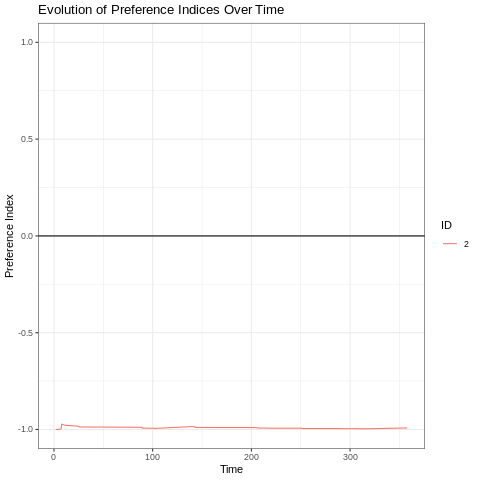

In [ ]:
%%R
ggplot(final_result[which(final_result$ID == 2),], aes(x = Time_min, y = Cumulative_PI, color = ID, group = ID)) +
  geom_line() +
  labs(title = "Evolution of Preference Indices Over Time",
       x = "Time",
       y = "Preference Index") + geom_hline(yintercept=0) + ylim(c(-1,1)) + theme_bw()

---
## New ideas

### Average bout duration by time in experiment and solution

### Drinking bout duration (continuous, uninterrupted prob contact) by count (y) and solution.
(Same Q as above: do bees drink the solutions for dif lengths of time, on average?)

### Cumulative number of bouts (y) by time in experiment (x) and solution
How does rate of feeding on each solution change over time?

### Cumulative volume of each solution drank over the experiment (estimated from time feeding and normalised by tube weight differences)